#  Analyse spectra holo at AuxTel for Configuration PSF1D


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 22th  2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

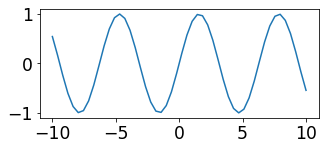

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-09-22'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [28]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

In [14]:
import pickle

# Calibration line

In [15]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20220629"
#DATE="20211104"
#filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [21]:
version="v5.0"

In [22]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini']
config_idx = 0
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_PSF1D'

In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini


In [25]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'PSF1D'

## Parameters

In [29]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

# Path

In [30]:
HOSTCC=True
LAPTOP=False

In [31]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [32]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629'

In [33]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Sep 21 21:31 2022062900058
drwxrws--- 1 dagoret lsst 2 Sep 21 20:37 2022062900087
drwxrws--- 1 dagoret lsst 2 Sep 21 21:31 2022062900088
drwxrws--- 1 dagoret lsst 2 Sep 21 21:28 2022062900089
drwxrws--- 1 dagoret lsst 2 Sep 21 21:30 2022062900117
drwxrws--- 1 dagoret lsst 2 Sep 21 21:31 2022062900141
drwxrws--- 1 dagoret lsst 2 Sep 21 21:30 2022062900143
drwxrws--- 1 dagoret lsst 2 Sep 21 21:30 2022062900168
drwxrws--- 1 dagoret lsst 2 Sep 21 21:29 2022062900169
drwxrws--- 1 dagoret lsst 2 Sep 21 21:29 2022062900170
drwxrws--- 1 dagoret lsst 2 Sep 21 21:29 2022062900171
drwxrws--- 1 dagoret lsst 2 Sep 21 21:30 2022062900206
drwxrws--- 1 dagoret lsst 2 Sep 21 21:30 2022062900207
drwxrws--- 1 dagoret lsst 2 Sep 21 21:31 2022062900208
drwxrws--- 1 dagoret lsst 2 Sep 21 21:31 2022062900302
drwxrws--- 1 dagoret lsst 2 Sep 21 21:29 2022062900303
drwxrws--- 1 dagoret lsst 2 Sep 21 21:31 2022062900304
drwxrws--- 1 dagoret lsst 2 Sep 21 21:31 2022062900305
dr

In [34]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini


In [35]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [36]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [37]:
df=pd.read_csv(filename_logbook,index_col=0)

In [38]:
pd.set_option('display.max_rows', None)

In [39]:
df

index                     date  \
0       0  2022-06-29T23:22:07.653   
1       1  2022-06-30T00:31:41.959   
2       2  2022-06-30T00:32:24.968   
3       3  2022-06-30T00:33:07.863   
4       4  2022-06-30T00:52:23.696   
5       5  2022-06-30T01:08:49.834   
6       6  2022-06-30T01:10:15.702   
7       7  2022-06-30T01:27:24.254   
8       8  2022-06-30T01:28:07.244   
9       9  2022-06-30T01:28:50.147   
10     10  2022-06-30T01:29:33.187   
11     11  2022-06-30T01:57:20.485   
12     12  2022-06-30T01:58:03.623   
13     13  2022-06-30T01:58:46.638   
14     14  2022-06-30T03:22:09.829   
15     15  2022-06-30T03:22:52.740   
16     16  2022-06-30T03:23:35.885   
17     17  2022-06-30T03:24:18.888   
18     18  2022-06-30T03:43:02.636   
19     19  2022-06-30T03:43:45.785   
20     20  2022-06-30T04:08:42.285   
21     21  2022-06-30T04:09:25.198   
22     22  2022-06-30T04:10:51.362   
23     23  2022-06-30T04:28:23.515   
24     24  2022-06-30T04:30:32.373   
25     25  2022-06-30T04:47:33.080   
26     26  2022-06-30T04:48:16.092   
27     27  2022-06-30T04:48:59.039   
28     28  2022-06-30T05:14:03.795   
29     29  2022-06-30T05:14:46.698   
30     30  2022-06-30T05:16:12.705   
31     31  2022-06-30T05:33:16.489   
32     32  2022-06-30T05:33:59.504   
33     33  2022-06-30T05:34:42.516   
34     34  2022-06-30T05:50:58.015   
35     35  2022-06-30T05:51:40.912   
36     36  2022-06-30T05:52:23.978   
37     37  2022-06-30T06:11:37.351   

                                                 path  \
0   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
1   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
2   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
3   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
4   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
5   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
6   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
7   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
8   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
9   /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
10  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
11  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
12  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
13  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
14  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
15  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
16  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
17  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
18  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
19  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
20  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
21  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
22  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
23  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
24  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
25  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
26  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
27  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
28  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
29  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
30  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
31  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
32  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
33  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
34  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
35  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
36  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   
37  /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...   

                                      file  num    object    filter  \
0   exposure_2022062900058_postisrccd.fits   58  HD142331  FELH0600   
1   exposure_2022062900087_postisrccd.fits   87  HD142331  FELH0600   
2   exposure_2022062900088_postisrccd.fits   88  HD142331  FELH0600   
3   exposure_

## Selection of input files

In [40]:
# Do not consider flag
#df_good=df[df["quality"]==1]

In [41]:
df_good=df
df_good["quality"] = 1

In [42]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022062900058_postisrccd.fits
exposure_2022062900087_postisrccd.fits
exposure_2022062900088_postisrccd.fits
exposure_2022062900089_postisrccd.fits
exposure_2022062900117_postisrccd.fits
exposure_2022062900141_postisrccd.fits
exposure_2022062900143_postisrccd.fits
exposure_2022062900168_postisrccd.fits
exposure_2022062900169_postisrccd.fits
exposure_2022062900170_postisrccd.fits
exposure_2022062900171_postisrccd.fits
exposure_2022062900206_postisrccd.fits
exposure_2022062900207_postisrccd.fits
exposure_2022062900208_postisrccd.fits
exposure_2022062900302_postisrccd.fits
exposure_2022062900303_postisrccd.fits
exposure_2022062900304_postisrccd.fits
exposure_2022062900305_postisrccd.fits
exposure_2022062900330_postisrccd.fits
exposure_2022062900331_postisrccd.fits
exposure_2022062900363_postisrccd.fits
exposure_2022062900364_postisrccd.fits
exposure_2022062900366_postisrccd.fits
exposure_2022062900390_postisrccd.fits
exposure_2022062900393_postisrccd.fits
exposure_2022062900418_po

## Selection of Spectractor output files

In [43]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [44]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022062900058', '2022062900087', '2022062900088', '2022062900089', '2022062900117', '2022062900141', '2022062900143', '2022062900168', '2022062900169', '2022062900170', '2022062900171', '2022062900206', '2022062900207', '2022062900208', '2022062900302', '2022062900303', '2022062900304', '2022062900305', '2022062900330', '2022062900331', '2022062900363', '2022062900366', '2022062900390', '2022062900393', '2022062900418', '2022062900419', '2022062900420', '2022062900450', '2022062900451', '2022062900453', '2022062900478', '2022062900479', '2022062900480', '2022062900504', '2022062900505', '2022062900506', '2022062900534']
00058
---------------------------------------------
2022062900058  	   00058
2022062900058 is a directory
tagname= 00058
dir_plots is not empty
dir_spectration is not empty
00087
---------------------------------------------
2022062900087  	   00087
2022062900087 is a directory
tagname= 00087
dir_plots is not empty
dir_spectration is not empty
00

In [45]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900058/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900087/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900088/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900089/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900117/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900141/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900143/ba

In [46]:
config

'./config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini'

## Extraction of spectra

In [47]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [48]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900058/basespec/exposure_2022062900058_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900087/basespec/exposure_2022062900087_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900088/basespec/exposure_2022062900088_postisrccd_spectrum.fits']

In [49]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900058/basespec/exposure_2022062900058_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900087/basespec/exposure_2022062900087_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900088/basespec/exposure_2022062900088_postisrccd_spectrogram.fits']

In [50]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900058/basespec/exposure_2022062900058_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900087/basespec/exposure_2022062900087_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900088/basespec/exposure_2022062900088_postisrccd_lines.csv']

In [51]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900058/basespec/exposure_2022062900058_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900087/basespec/exposure_2022062900087_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900088/basespec/exposure_2022062900088_postisrccd_table.csv']

## Selection of good spectra

In [52]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [53]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

In [54]:
FLAG_RECALIB

False

9 ) exposure_2022062900170_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900170/basespec/exposure_2022062900170_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:29:20.379
set expo to 30.0
set airmass to 1.08811087454229
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.512533383392288
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 757.6064176310742
set parallactic_angle to -158.9491418446658


2022-09-22 14:48:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.
2022-09-22 14:48:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = HD142331, Selected object name for Simbad : HD142331
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


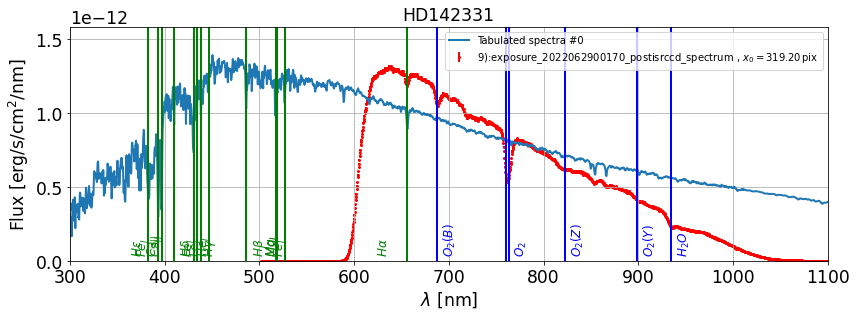

In [55]:
#idx=7 # Big Shift
#idx = 8 # Shift, I don't know why
idx = 9 # OK
#idx = 10 # OK
#idx = 11 # OK
#idx = 12 # 0K
#idx = 13 # strange shift after recalib
#idx = 14 # OK
#idx = 15 # Shift
#idx = 16 # BAD Spectrum Nothing
#idx = 17 # OK
#idx = 18 # trange shift after recalib
#idx = 19 # OK
#idx = 20 # OK
#idx = 21 # OK
#idx = 22 # BAD Spectrum
#idx = 24 # OK


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True,label=label)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

In [56]:
parameters.DEBUG=False
parameters.LIVE_FIT=False

## All Spectra

============================ 0 ) exposure_2022062900058_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900058/basespec/exposure_2022062900058_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T23:22:37.887
set expo to 30.0
set airmass to 1.388780155371592
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.25958814076518
set temperature to 9.5
set pressure to 743.85
set humidity to 12.0
set lambda_ref to 759.2267045960177
set parallactic_angle to -125.1518062613792
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:44:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 1 ) exposure_2022062900087_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900087/basespec/exposure_2022062900087_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:32:12.198
set expo to 30.0
set airmass to 1.164824633047409
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -23.82492695376337
set temperature to 9.6
set pressure to 744.35
set humidity to 13.0
set lambda_ref to 757.8451

2022-09-22 15:44:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_3  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 2 ) exposure_2022062900088_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900088/basespec/exposure_2022062900088_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:32:55.197
set expo to 30.0
set airmass to 1.16337197195567
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -23.64503982977181
set temperature to 9.6
set pressure to 744.35
set humidity to 13.0
set lambda_ref to 804.46050

2022-09-22 15:44:06  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_4  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 3 ) exposure_2022062900089_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900089/basespec/exposure_2022062900089_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:33:38.095
set expo to 30.0
set airmass to 1.16193748088144
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -23.46619711892746
set temperature to 9.5
set pressure to 744.35
set humidity to 14.0
set lambda_ref to 758.57001

2022-09-22 15:44:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_5  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 4 ) exposure_2022062900117_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900117/basespec/exposure_2022062900117_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:52:53.929
set expo to 30.0
set airmass to 1.12831064590449
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -18.63980053879423
set temperature to 9.9
set pressure to 744.35
set humidity to 17.0
set lambda_ref to 758.00620

2022-09-22 15:44:12  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_6  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 5 ) exposure_2022062900141_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900141/basespec/exposure_2022062900141_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:09:20.071
set expo to 30.0
set airmass to 1.106639001671546
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -14.52421849815381
set temperature to 9.6
set pressure to 744.2
set humidity to 15.0
set lambda_ref to 756.67068

2022-09-22 15:44:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_7  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 6 ) exposure_2022062900143_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900143/basespec/exposure_2022062900143_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:10:45.940
set expo to 30.0
set airmass to 1.105030269908044
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -14.16486919860989
set temperature to 9.7
set pressure to 744.3
set humidity to 16.0
set lambda_ref to 756.40239

2022-09-22 15:44:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_8  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 7 ) exposure_2022062900168_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900168/basespec/exposure_2022062900168_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:27:54.494
set expo to 30.0
set airmass to 1.089167163770014
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.871248156041085
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 757.7558

2022-09-22 15:44:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_9  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 8 ) exposure_2022062900169_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900169/basespec/exposure_2022062900169_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:28:37.468
set expo to 30.0
set airmass to 1.088634062728323
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.692415054774967
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 757.8292

2022-09-22 15:44:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_10 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 9 ) exposure_2022062900170_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900170/basespec/exposure_2022062900170_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:29:20.379
set expo to 30.0
set airmass to 1.08811087454229
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.512533383392288
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 757.60641

2022-09-22 15:44:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_11 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 10 ) exposure_2022062900171_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900171/basespec/exposure_2022062900171_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:30:03.413
set expo to 30.0
set airmass to 1.087597037592785
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.3328624426554
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 756.60848

2022-09-22 15:44:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_12 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 11 ) exposure_2022062900206_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900206/basespec/exposure_2022062900206_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:57:50.734
set expo to 30.0
set airmass to 1.075492079937127
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.374761991553928
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 15.0
set lambda_ref

2022-09-22 15:44:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_13 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 12 ) exposure_2022062900207_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900207/basespec/exposure_2022062900207_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:58:33.862
set expo to 30.0
set airmass to 1.075371864901717
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.195092553165682
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 15.0
set lambda_ref

2022-09-22 15:44:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_14 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 13 ) exposure_2022062900208_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900208/basespec/exposure_2022062900208_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:59:16.887
set expo to 30.0
set airmass to 1.075261271771509
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.015212904178237
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 15.0
set lambda_ref

2022-09-22 15:44:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_15 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 14 ) exposure_2022062900302_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900302/basespec/exposure_2022062900302_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:22:40.072
set expo to 30.0
set airmass to 1.130894299575967
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 18.89147376327531
set temperature to 10.0
set pressure to 744.3
set humidity to 9.0
set lambda_ref to 758.68294

2022-09-22 15:44:36  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_16 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 15 ) exposure_2022062900303_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900303/basespec/exposure_2022062900303_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:23:22.975
set expo to 30.0
set airmass to 1.132005269014125
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.07114754074388
set temperature to 10.0
set pressure to 744.3
set humidity to 9.0
set lambda_ref to 755.57915

2022-09-22 15:44:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_17 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 16 ) exposure_2022062900304_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900304/basespec/exposure_2022062900304_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:24:06.121
set expo to 30.0
set airmass to 1.133133169983545
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.25082078240246
set temperature to 10.1
set pressure to 744.3
set humidity to 9.0
set lambda_ref to 758.92716

2022-09-22 15:44:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_18 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 17 ) exposure_2022062900305_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900305/basespec/exposure_2022062900305_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:24:49.118
set expo to 30.0
set airmass to 1.134271531478473
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.43070489992349
set temperature to 10.0
set pressure to 744.3
set humidity to 9.0
set lambda_ref to 756.90385

2022-09-22 15:44:44  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_19 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 18 ) exposure_2022062900330_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900330/basespec/exposure_2022062900330_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:43:32.887
set expo to 30.0
set airmass to 1.168658657441516
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 24.12827305623597
set temperature to 10.1
set pressure to 744.0999999999999
set humidity to 10.0
set lambda_ref

2022-09-22 15:44:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_20 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 19 ) exposure_2022062900331_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900331/basespec/exposure_2022062900331_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:44:16.022
set expo to 30.0
set airmass to 1.170164376452688
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 24.30878193717385
set temperature to 10.1
set pressure to 744.05
set humidity to 9.0
set lambda_ref to 757.1203

2022-09-22 15:44:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_21 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 20 ) exposure_2022062900363_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900363/basespec/exposure_2022062900363_postisrccd_spectrum.fits ==============================


/tmp/ipykernel_868/2289102767.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16,4))


No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:09:12.518
set expo to 30.0
set airmass to 1.86751661431128
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -39.33498541782655
set temperature to 10.2
set pressure to 743.85
set humidity to 10.0
set lambda_ref to 759.6501487439608
set parallactic_angle to -40.3162171142111
target_name = HD185975, Selected object name for Simbad : HD185975


2022-09-22 15:44:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_22 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 21 ) exposure_2022062900366_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900366/basespec/exposure_2022062900366_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:11:21.596
set expo to 30.0
set airmass to 1.866716841063486
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -38.79575326502005
set temperature to 10.1
set pressure to 743.8
set humidity to 10.0
set lambda_ref to 760.522

2022-09-22 15:44:52  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_23 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
=== ORIGINAL CALIB lines === 
============================ 22 ) exposure_2022062900390_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900390/basespec/exposure_2022062900390_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:28:53.760
set expo to 30.0
set airmass to 1.295797892410749
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 35.49755447823504
set temperature to 10.2
set pressure to 743.7
set humidity to 11.0
set lambda_ref to 741.8226

2022-09-22 15:44:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_24 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 23 ) exposure_2022062900393_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900393/basespec/exposure_2022062900393_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:31:02.609
set expo to 30.0
set airmass to 1.303697342246742
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 36.03575058903911
set temperature to 10.2
set pressure to 743.75
set humidity to 10.0
set lambda_ref to 758.410

2022-09-22 15:44:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_25 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 24 ) exposure_2022062900418_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900418/basespec/exposure_2022062900418_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:48:03.322
set expo to 30.0
set airmass to 1.373891871687385
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.30227320324827
set temperature to 10.1
set pressure to 743.65
set humidity to 11.0
set lambda_ref to 792.929

2022-09-22 15:44:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_26 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


/opt/conda/lib/python3.8/site-packages/numpy/polynomial/legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


=== ORIGINAL CALIB lines === 
============================ 25 ) exposure_2022062900419_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900419/basespec/exposure_2022062900419_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:48:46.341
set expo to 30.0
set airmass to 1.37715769216016
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.48195372903069
set temperature to 10.1
set pressure to 743.65
set humidity to 11.0
set lambda_ref to 759.4922957385281
set parallactic_angle to 125.4985289995639
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:45:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_27 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 26 ) exposure_2022062900420_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900420/basespec/exposure_2022062900420_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:49:29.273
set expo to 30.0
set airmass to 1.38045884104267
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.66163398356275
set temperature to 10.1
set pressure to 743.65
set humidity to 11.0
set lambda_ref to 757.7460

2022-09-22 15:45:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_28 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 27 ) exposure_2022062900450_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900450/basespec/exposure_2022062900450_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:14:34.027
set expo to 30.0
set airmass to 1.515609943706119
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 46.95113209167098
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 759.8264

2022-09-22 15:45:10  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_29 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 28 ) exposure_2022062900451_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900451/basespec/exposure_2022062900451_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:15:16.921
set expo to 30.0
set airmass to 1.520101344402848
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 47.13018190162078
set temperature to 10.2
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 767.8918

2022-09-22 15:45:12  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_30 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 29 ) exposure_2022062900453_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900453/basespec/exposure_2022062900453_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:16:42.937
set expo to 30.0
set airmass to 1.529220045860235
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 47.48953793514802
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 759.6840

2022-09-22 15:45:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_31 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 30 ) exposure_2022062900478_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900478/basespec/exposure_2022062900478_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:33:46.746
set expo to 30.0
set airmass to 1.651452825304327
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.76883236790696
set temperature to 10.2
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 760.0855

2022-09-22 15:45:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_32 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 31 ) exposure_2022062900479_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900479/basespec/exposure_2022062900479_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:34:29.749
set expo to 30.0
set airmass to 1.657193993900907
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.94850947923488
set temperature to 10.2
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 760.4125

2022-09-22 15:45:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_33 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 32 ) exposure_2022062900480_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900480/basespec/exposure_2022062900480_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:35:12.762
set expo to 30.0
set airmass to 1.662979234505849
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 52.12755852680557
set temperature to 10.2
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 760.081

2022-09-22 15:45:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_34 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 33 ) exposure_2022062900504_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900504/basespec/exposure_2022062900504_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:51:28.246
set expo to 30.0
set airmass to 1.810606864700533
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.20369947739367
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 760.4577

2022-09-22 15:45:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_35 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 34 ) exposure_2022062900505_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900505/basespec/exposure_2022062900505_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:52:11.149
set expo to 30.0
set airmass to 1.817910365606639
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.38337617373983
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 715.3166

2022-09-22 15:45:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_36 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 35 ) exposure_2022062900506_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900506/basespec/exposure_2022062900506_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:52:54.221
set expo to 30.0
set airmass to 1.825283914547275
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.56305070777198
set temperature to 10.4
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 760.218

2022-09-22 15:45:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_37 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 
============================ 36 ) exposure_2022062900534_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900534/basespec/exposure_2022062900534_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T06:12:07.585
set expo to 30.0
set airmass to 2.054927504167972
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 61.38268263164381
set temperature to 10.3
set pressure to 743.45
set humidity to 12.0
set lambda_ref to 760.619

2022-09-22 15:45:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_38 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
=== ORIGINAL CALIB lines === 


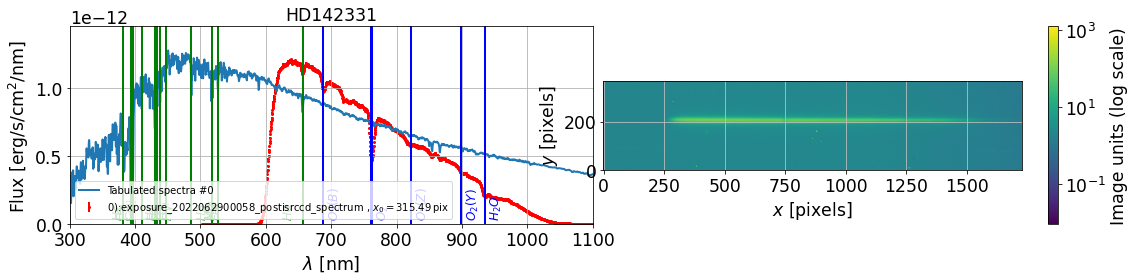

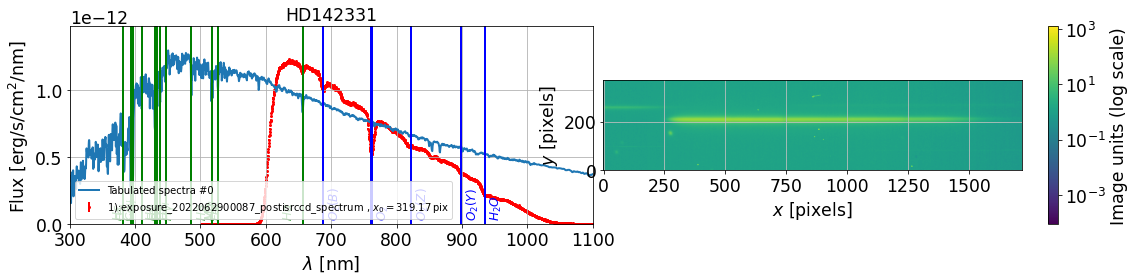

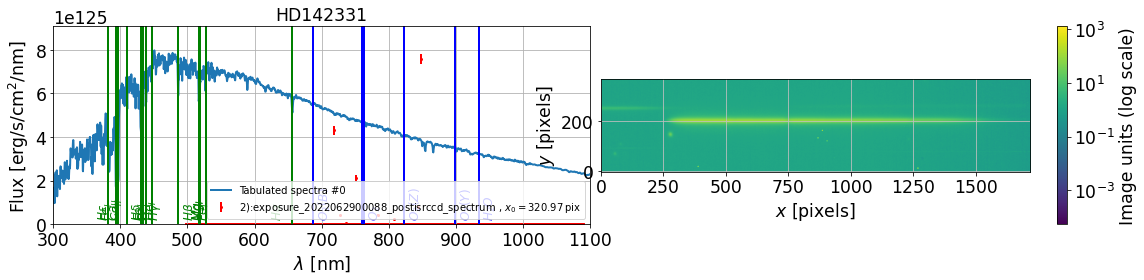

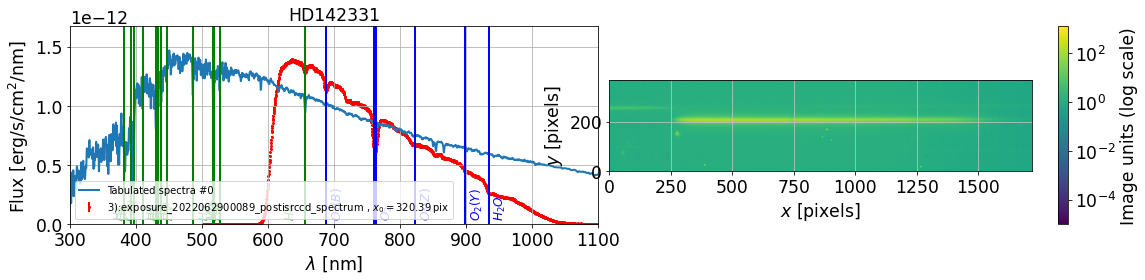

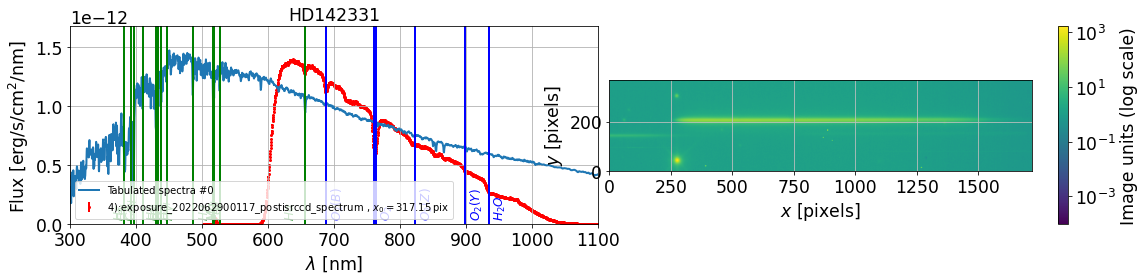

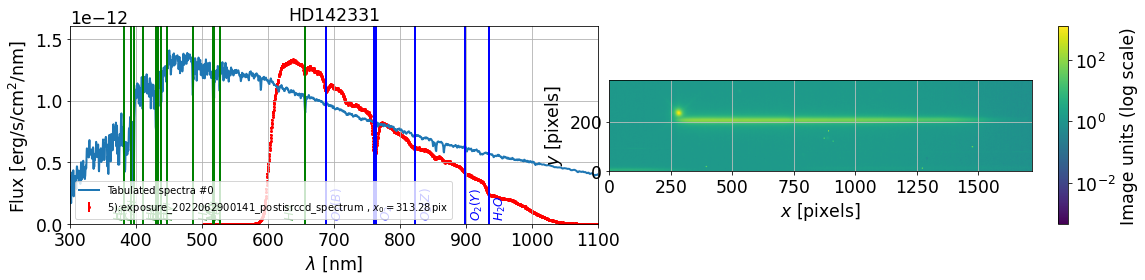

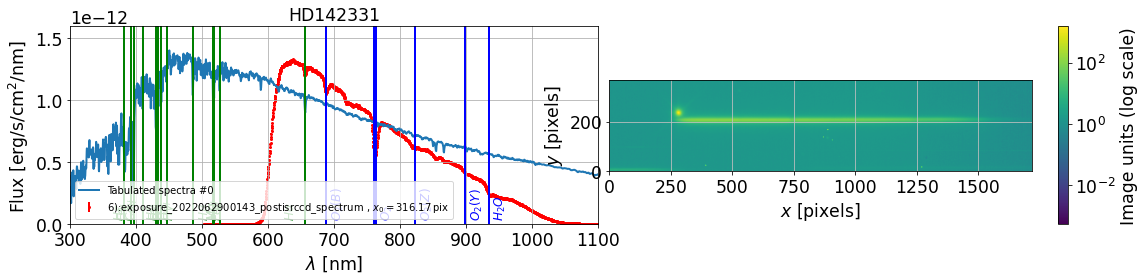

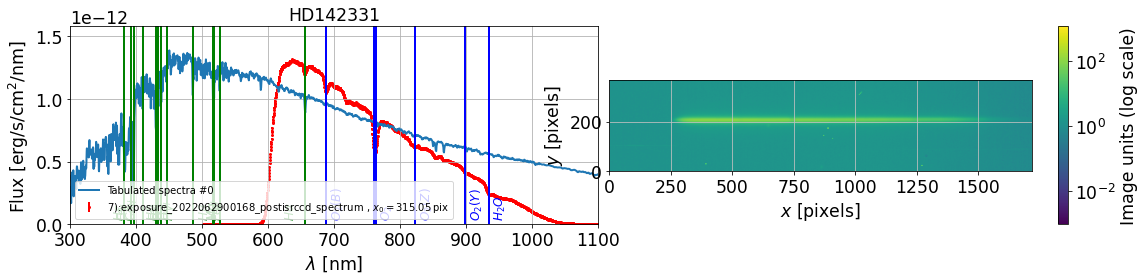

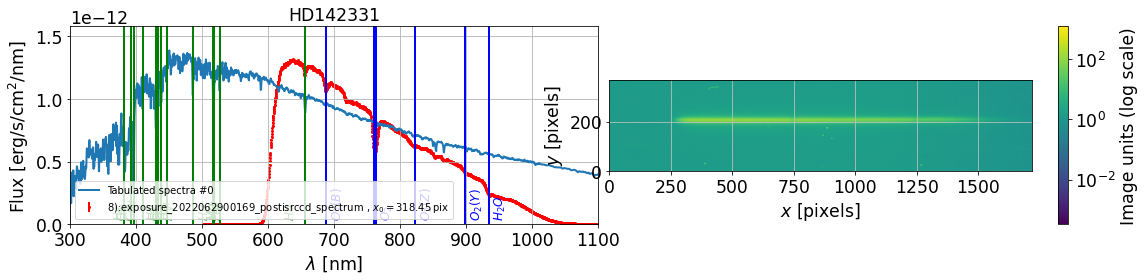

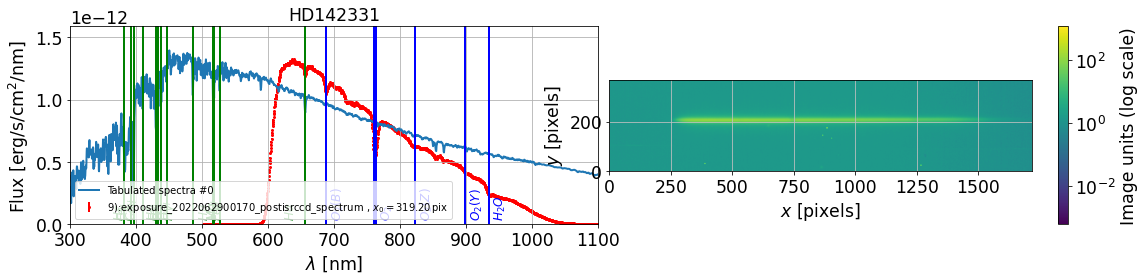

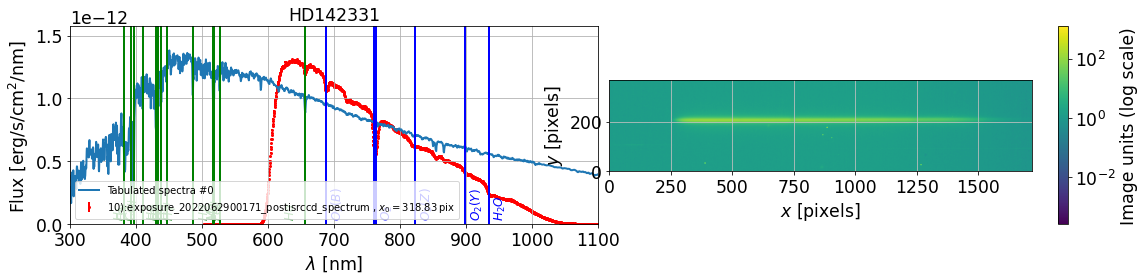

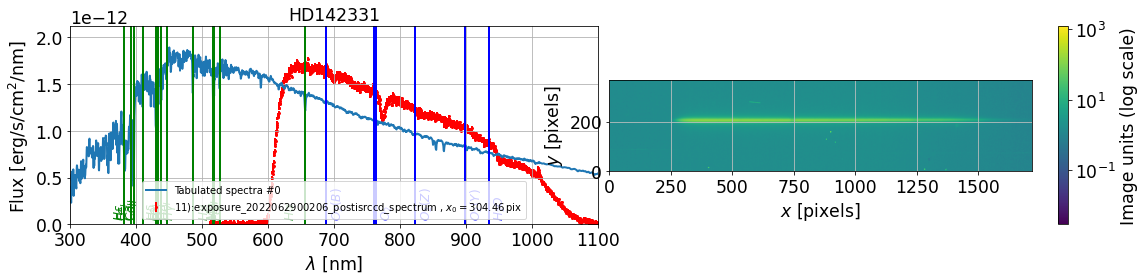

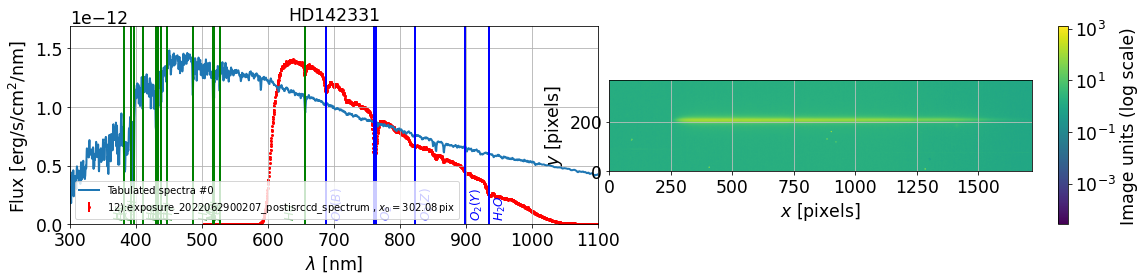

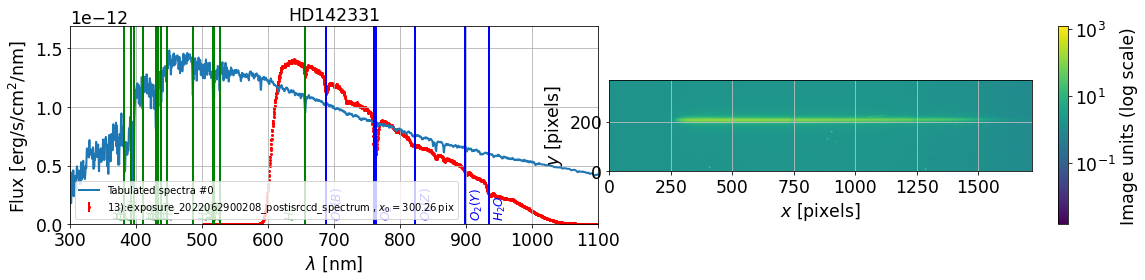

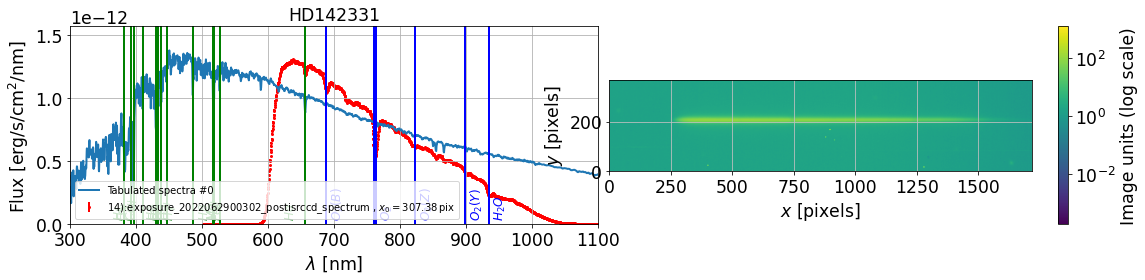

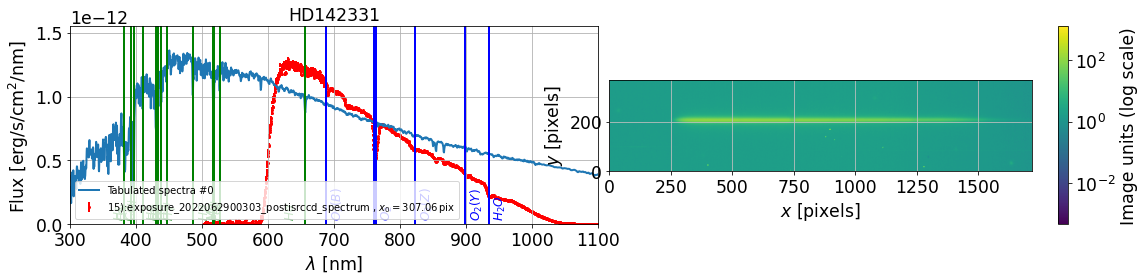

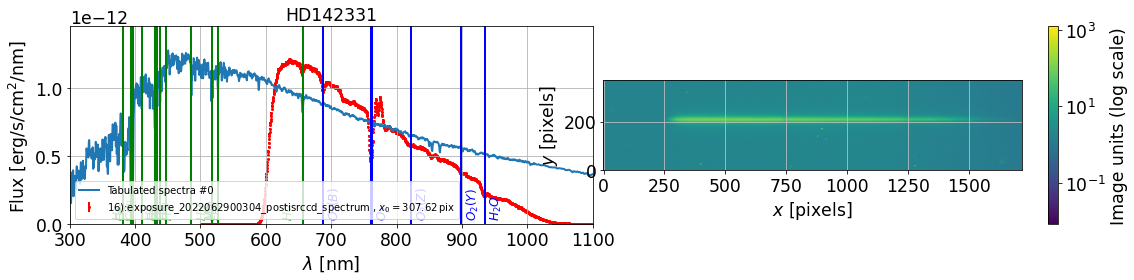

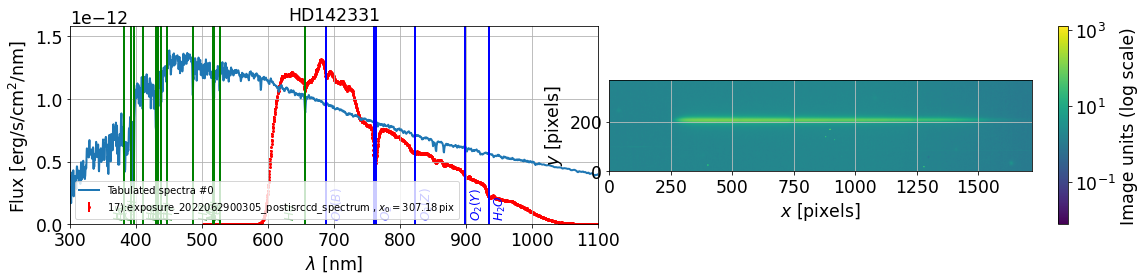

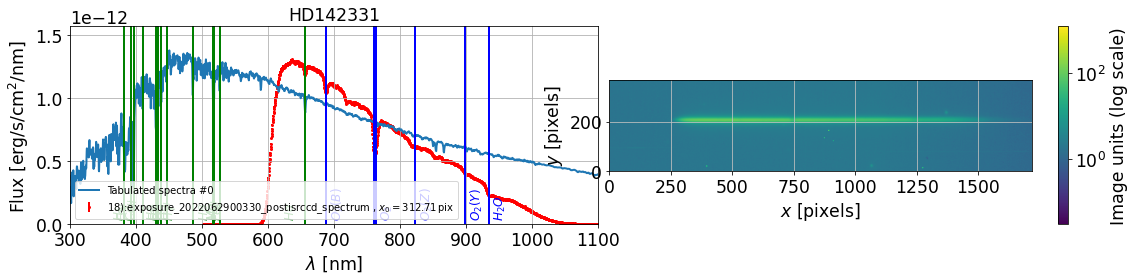

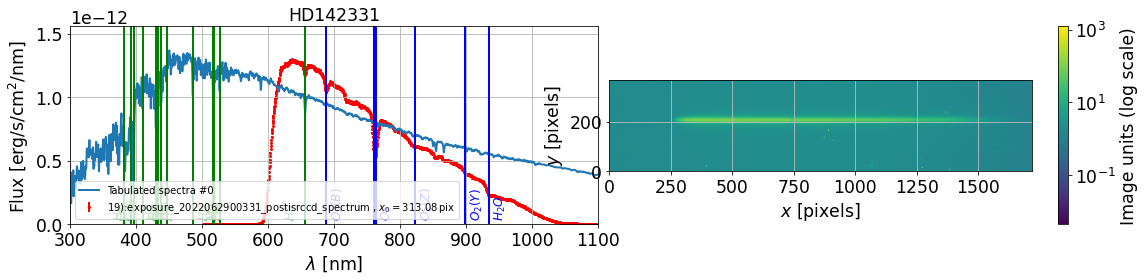

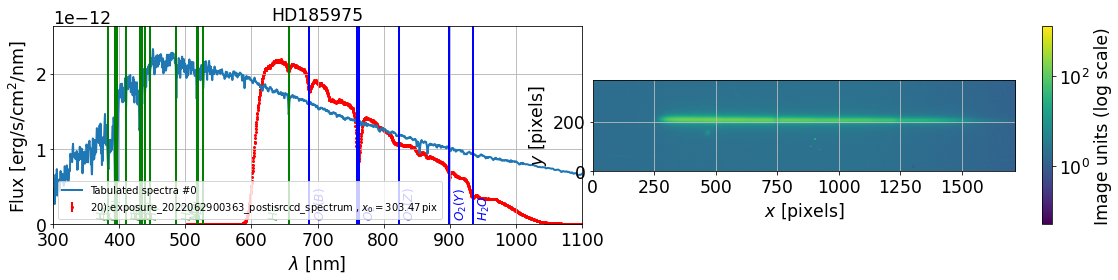

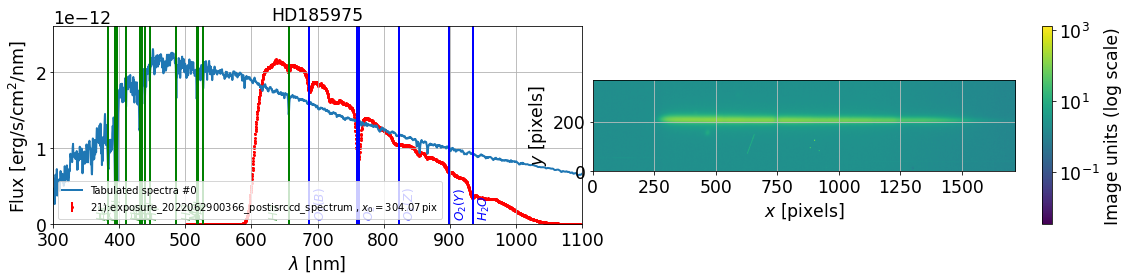

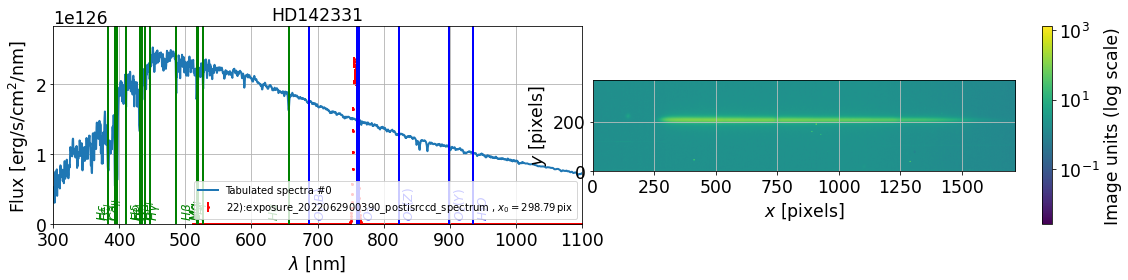

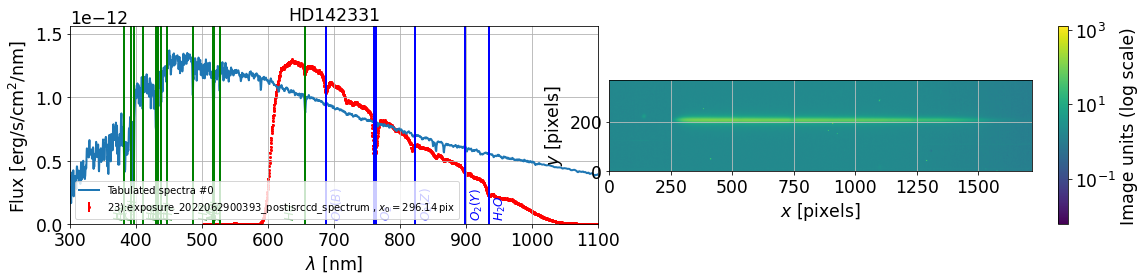

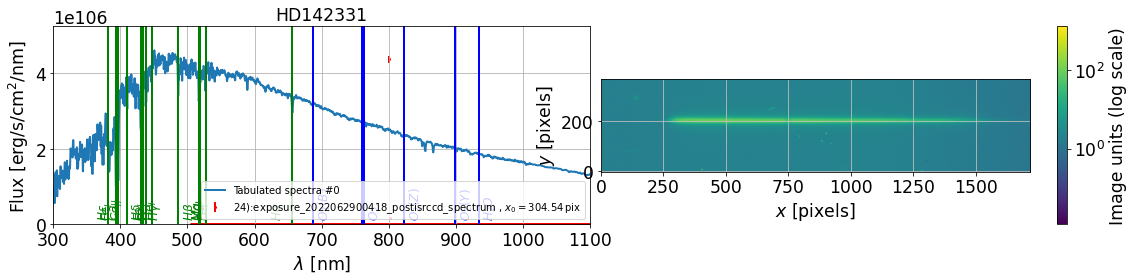

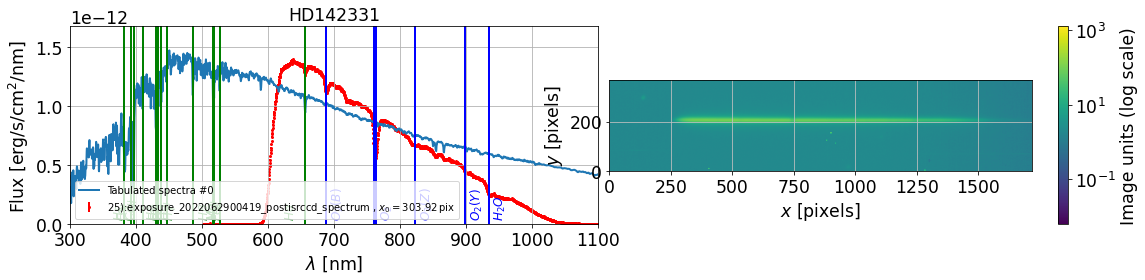

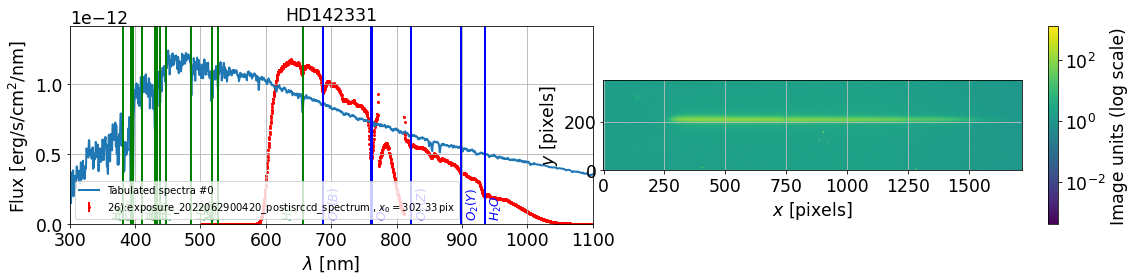

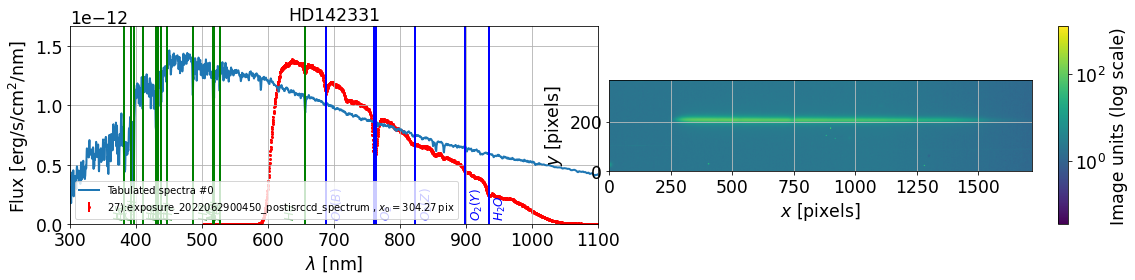

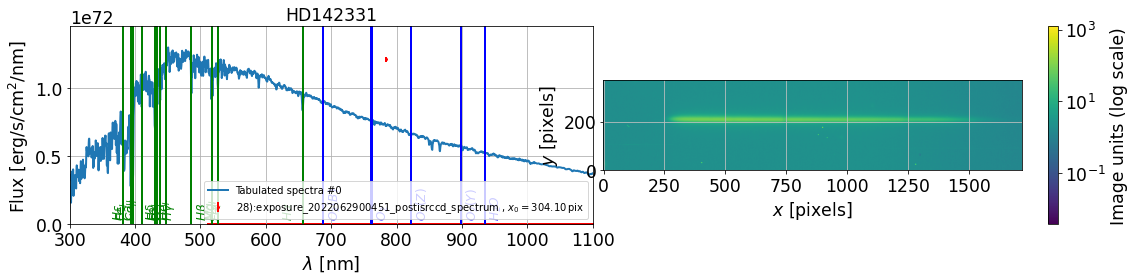

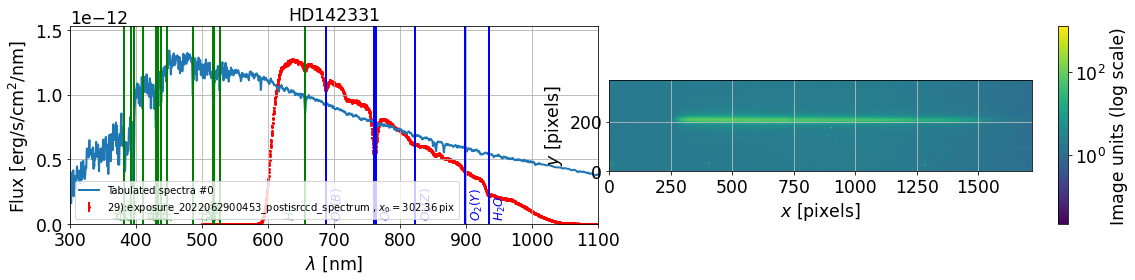

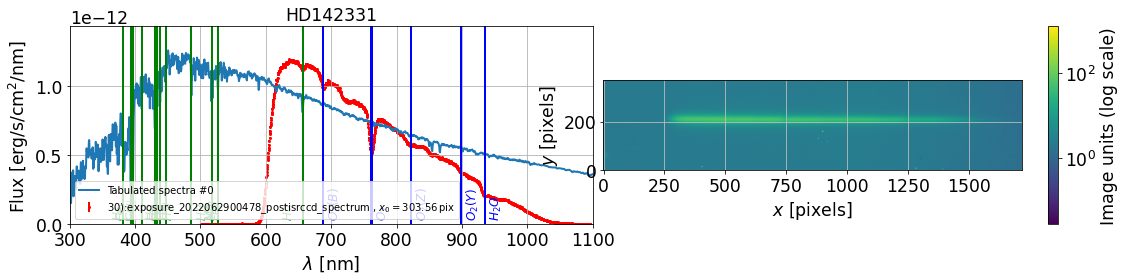

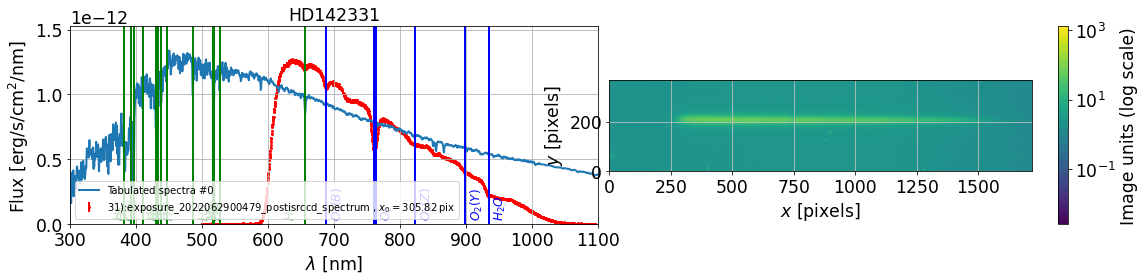

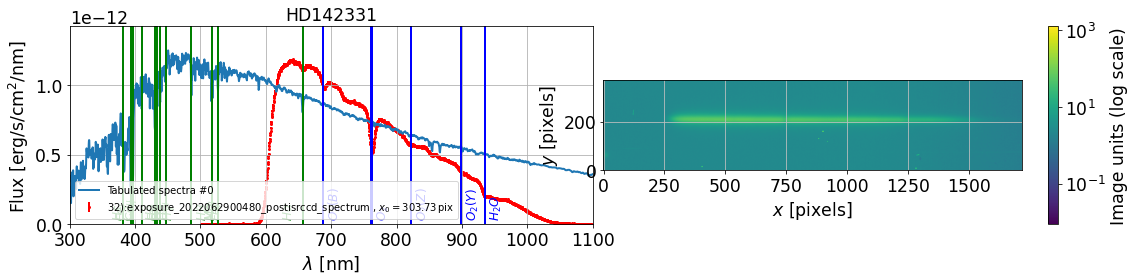

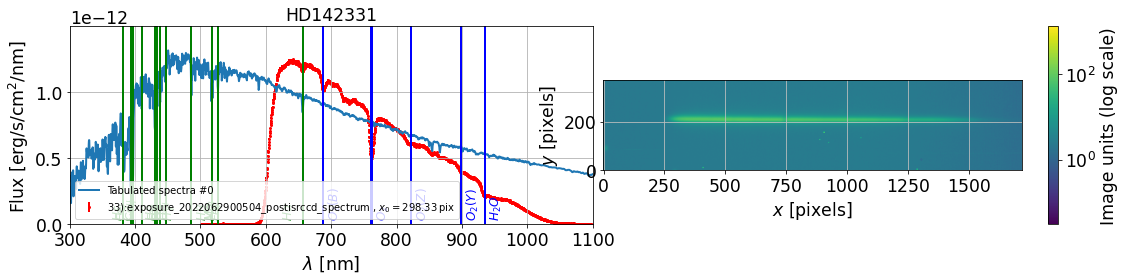

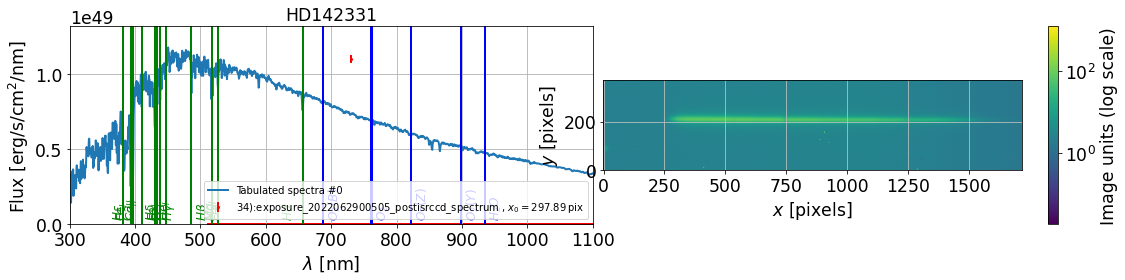

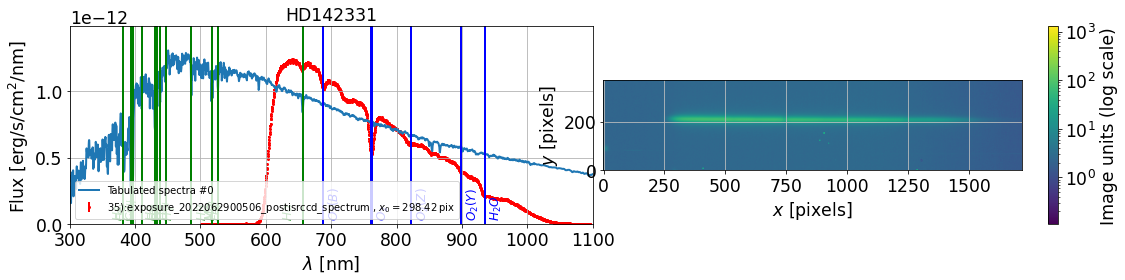

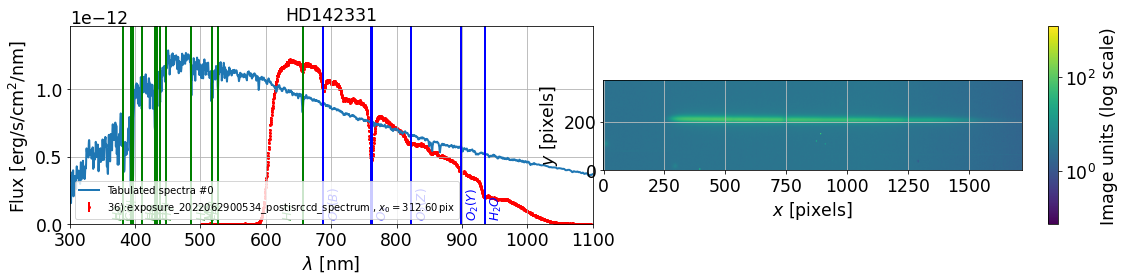

In [58]:
parameters.DISPLAY=True

FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    print("=== ORIGINAL CALIB lines === ")
    s.lines.print_detected_lines(print_table=True)
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    all_figs.append(fig)
    
    idx+=1
    

## Save figures in a pdf filename

In [59]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        s=Spectrum(fullfilename, config=config,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [60]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [61]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        
    
    

### Individual spectra

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/8.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-29T23:22:37.887
set expo to 30.0
set airmass to 1.388780155371592
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -41.25958814076518
set temperature to 9.5
set pressure to 743.85
set humidity to 12.0
set lambda_ref to 759.2267045960177
set parallactic_angle to -125.1518062613792
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_39 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/8.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:32:12.198
set expo to 30.0
set airmass to 1.164824633047409
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -23.82492695376337
set temperature to 9.6
set pressure to 744.35
set humidity to 13.0
set lambda_ref to 757.845182469731
set parallactic_angle to -137.4495709921531
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_40 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/8.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:32:55.197
set expo to 30.0
set airmass to 1.16337197195567
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -23.64503982977181
set temperature to 9.6
set pressure to 744.35
set humidity to 13.0
set lambda_ref to 804.4605083714345
set parallactic_angle to -137.6410938416775
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:16  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_41 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/8.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:33:38.095
set expo to 30.0
set airmass to 1.16193748088144
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -23.46619711892746
set temperature to 9.5
set pressure to 744.35
set humidity to 14.0
set lambda_ref to 758.5700181405618
set parallactic_angle to -137.8332006346826
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_42 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 1/8.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:52:53.929
set expo to 30.0
set airmass to 1.12831064590449
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -18.63980053879423
set temperature to 9.9
set pressure to 744.35
set humidity to 17.0
set lambda_ref to 758.0062060135789
set parallactic_angle to -143.7033833493595
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_43 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/8.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:09:20.071
set expo to 30.0
set airmass to 1.106639001671546
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -14.52421849815381
set temperature to 9.6
set pressure to 744.2
set humidity to 15.0
set lambda_ref to 756.6706864467681
set parallactic_angle to -149.8694368014291
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_44 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 6, pagenum = 2/8.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:10:45.940
set expo to 30.0
set airmass to 1.105030269908044
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -14.16486919860989
set temperature to 9.7
set pressure to 744.3
set humidity to 16.0
set lambda_ref to 756.4023951586249
set parallactic_angle to -150.4626128176785
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_45 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 7, pagenum = 2/8.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:27:54.494
set expo to 30.0
set airmass to 1.089167163770014
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.871248156041085
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 757.7558476965364
set parallactic_angle to -158.2426015622007
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_46 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 8, pagenum = 2/8.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:28:37.468
set expo to 30.0
set airmass to 1.088634062728323
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.692415054774967
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 757.8292114622263
set parallactic_angle to -158.5937925032367
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:24  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_47 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 9, pagenum = 2/8.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:29:20.379
set expo to 30.0
set airmass to 1.08811087454229
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.512533383392288
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 757.6064176310742
set parallactic_angle to -158.9491418446658
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_48 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 10, pagenum = 3/8.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:30:03.413
set expo to 30.0
set airmass to 1.087597037592785
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -9.3328624426554
set temperature to 9.9
set pressure to 744.25
set humidity to 16.0
set lambda_ref to 756.6084876208009
set parallactic_angle to -159.306160340009
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_49 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 11, pagenum = 3/8.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:57:50.734
set expo to 30.0
set airmass to 1.075492079937127
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.374761991553928
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 15.0
set lambda_ref to 786.1510849131308
set parallactic_angle to -174.4634051507153
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_50 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 12, pagenum = 3/8.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:58:33.862
set expo to 30.0
set airmass to 1.075371864901717
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.195092553165682
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 15.0
set lambda_ref to 757.7667329097596
set parallactic_angle to -174.8795408446391
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_51 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 13, pagenum = 3/8.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T01:59:16.887
set expo to 30.0
set airmass to 1.075261271771509
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -2.015212904178237
set temperature to 9.9
set pressure to 744.4000000000001
set humidity to 15.0
set lambda_ref to 757.6597920025469
set parallactic_angle to -175.2968094735171
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_52 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 14, pagenum = 3/8.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:22:40.072
set expo to 30.0
set airmass to 1.130894299575967
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 18.89147376327531
set temperature to 10.0
set pressure to 744.3
set humidity to 9.0
set lambda_ref to 758.6829427922149
set parallactic_angle to 143.3625828666895
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:34  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_53 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 15, pagenum = 4/8.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:23:22.975
set expo to 30.0
set airmass to 1.132005269014125
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.07114754074388
set temperature to 10.0
set pressure to 744.3
set humidity to 9.0
set lambda_ref to 755.5791576473746
set parallactic_angle to 143.1217352299002
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_54 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 16, pagenum = 4/8.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:24:06.121
set expo to 30.0
set airmass to 1.133133169983545
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.25082078240246
set temperature to 10.1
set pressure to 744.3
set humidity to 9.0
set lambda_ref to 758.9271661622441
set parallactic_angle to 142.882920974999
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_55 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 17, pagenum = 4/8.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:24:49.118
set expo to 30.0
set airmass to 1.134271531478473
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 19.43070489992349
set temperature to 10.0
set pressure to 744.3
set humidity to 9.0
set lambda_ref to 756.9038566069473
set parallactic_angle to 142.6458509574369
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_56 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 18, pagenum = 4/8.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:43:32.887
set expo to 30.0
set airmass to 1.168658657441516
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 24.12827305623597
set temperature to 10.1
set pressure to 744.0999999999999
set humidity to 10.0
set lambda_ref to 756.9213221810076
set parallactic_angle to 137.130441406835
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_57 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 19, pagenum = 4/8.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T03:44:16.022
set expo to 30.0
set airmass to 1.170164376452688
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 24.30878193717385
set temperature to 10.1
set pressure to 744.05
set humidity to 9.0
set lambda_ref to 757.1203490603358
set parallactic_angle to 136.9428051918837
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_58 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 20, pagenum = 5/8.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:09:12.518
set expo to 30.0
set airmass to 1.86751661431128
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -39.33498541782655
set temperature to 10.2
set pressure to 743.85
set humidity to 10.0
set lambda_ref to 759.6501487439608
set parallactic_angle to -40.3162171142111
target_name = HD185975, Selected object name for Simbad : HD185975


2022-09-22 15:50:44  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_59 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 21, pagenum = 5/8.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:11:21.596
set expo to 30.0
set airmass to 1.866716841063486
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -87.47219444444444
set hour_angle to -38.79575326502005
set temperature to 10.1
set pressure to 743.8
set humidity to 10.0
set lambda_ref to 760.5225935336091
set parallactic_angle to -39.76604662249773
target_name = HD185975, Selected object name for Simbad : HD185975


2022-09-22 15:50:46  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_60 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 22, pagenum = 5/8.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:28:53.760
set expo to 30.0
set airmass to 1.295797892410749
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 35.49755447823504
set temperature to 10.2
set pressure to 743.7
set humidity to 11.0
set lambda_ref to 741.82265932707
set parallactic_angle to 128.0854706740056
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_61 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 23, pagenum = 5/8.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:31:02.609
set expo to 30.0
set airmass to 1.303697342246742
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 36.03575058903911
set temperature to 10.2
set pressure to 743.75
set humidity to 10.0
set lambda_ref to 758.4105257302483
set parallactic_angle to 127.7731727377382
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_62 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 24, pagenum = 5/8.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:48:03.322
set expo to 30.0
set airmass to 1.373891871687385
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.30227320324827
set temperature to 10.1
set pressure to 743.65
set humidity to 11.0
set lambda_ref to 792.9292045696766
set parallactic_angle to 125.5806649083276
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_63 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


/opt/conda/lib/python3.8/site-packages/numpy/polynomial/legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 25, pagenum = 6/8.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:48:46.341
set expo to 30.0
set airmass to 1.37715769216016
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.48195372903069
set temperature to 10.1
set pressure to 743.65
set humidity to 11.0
set lambda_ref to 759.4922957385281
set parallactic_angle to 125.4985289995639
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_64 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 26, pagenum = 6/8.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T04:49:29.273
set expo to 30.0
set airmass to 1.38045884104267
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 40.66163398356275
set temperature to 10.1
set pressure to 743.65
set humidity to 11.0
set lambda_ref to 757.7460680851642
set parallactic_angle to 125.4171592276134
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_65 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 27, pagenum = 6/8.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:14:34.027
set expo to 30.0
set airmass to 1.515609943706119
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 46.95113209167098
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 759.826427113966
set parallactic_angle to 123.0064911760373
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:57  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_66 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 28, pagenum = 6/8.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:15:16.921
set expo to 30.0
set airmass to 1.520101344402848
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 47.13018190162078
set temperature to 10.2
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 767.891866808095
set parallactic_angle to 122.9491589967838
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:50:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_67 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 29, pagenum = 6/8.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:16:42.937
set expo to 30.0
set airmass to 1.529220045860235
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 47.48953793514802
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 759.6840177384189
set parallactic_angle to 122.8357999126726
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:51:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_68 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 30, pagenum = 7/8.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:33:46.746
set expo to 30.0
set airmass to 1.651452825304327
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.76883236790696
set temperature to 10.2
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 760.0855746821003
set parallactic_angle to 121.6501227487718
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:51:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_69 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 31, pagenum = 7/8.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:34:29.749
set expo to 30.0
set airmass to 1.657193993900907
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 51.94850947923488
set temperature to 10.2
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 760.4125974485208
set parallactic_angle to 121.6065570959233
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:51:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_70 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 32, pagenum = 7/8.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:35:12.762
set expo to 30.0
set airmass to 1.662979234505849
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 52.12755852680557
set temperature to 10.2
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 760.081962790663
set parallactic_angle to 121.5636128760584
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:51:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_71 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 33, pagenum = 7/8.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:51:28.246
set expo to 30.0
set airmass to 1.810606864700533
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.20369947739367
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 760.4577758215579
set parallactic_angle to 120.7060217580026
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:51:09  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_72 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 34, pagenum = 7/8.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:52:11.149
set expo to 30.0
set airmass to 1.817910365606639
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.38337617373983
set temperature to 10.3
set pressure to 743.7
set humidity to 12.0
set lambda_ref to 715.3166114559618
set parallactic_angle to 120.6732392059004
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:51:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_73 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 35, pagenum = 8/8.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T05:52:54.221
set expo to 30.0
set airmass to 1.825283914547275
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 56.56305070777198
set temperature to 10.4
set pressure to 743.75
set humidity to 12.0
set lambda_ref to 760.2185770079511
set parallactic_angle to 120.6408594878693
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:51:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_74 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 36, pagenum = 8/8.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T06:12:07.585
set expo to 30.0
set airmass to 2.054927504167972
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to 61.38268263164381
set temperature to 10.3
set pressure to 743.45
set humidity to 12.0
set lambda_ref to 760.6196691974278
set parallactic_angle to 119.9143794504713
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:51:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_75 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


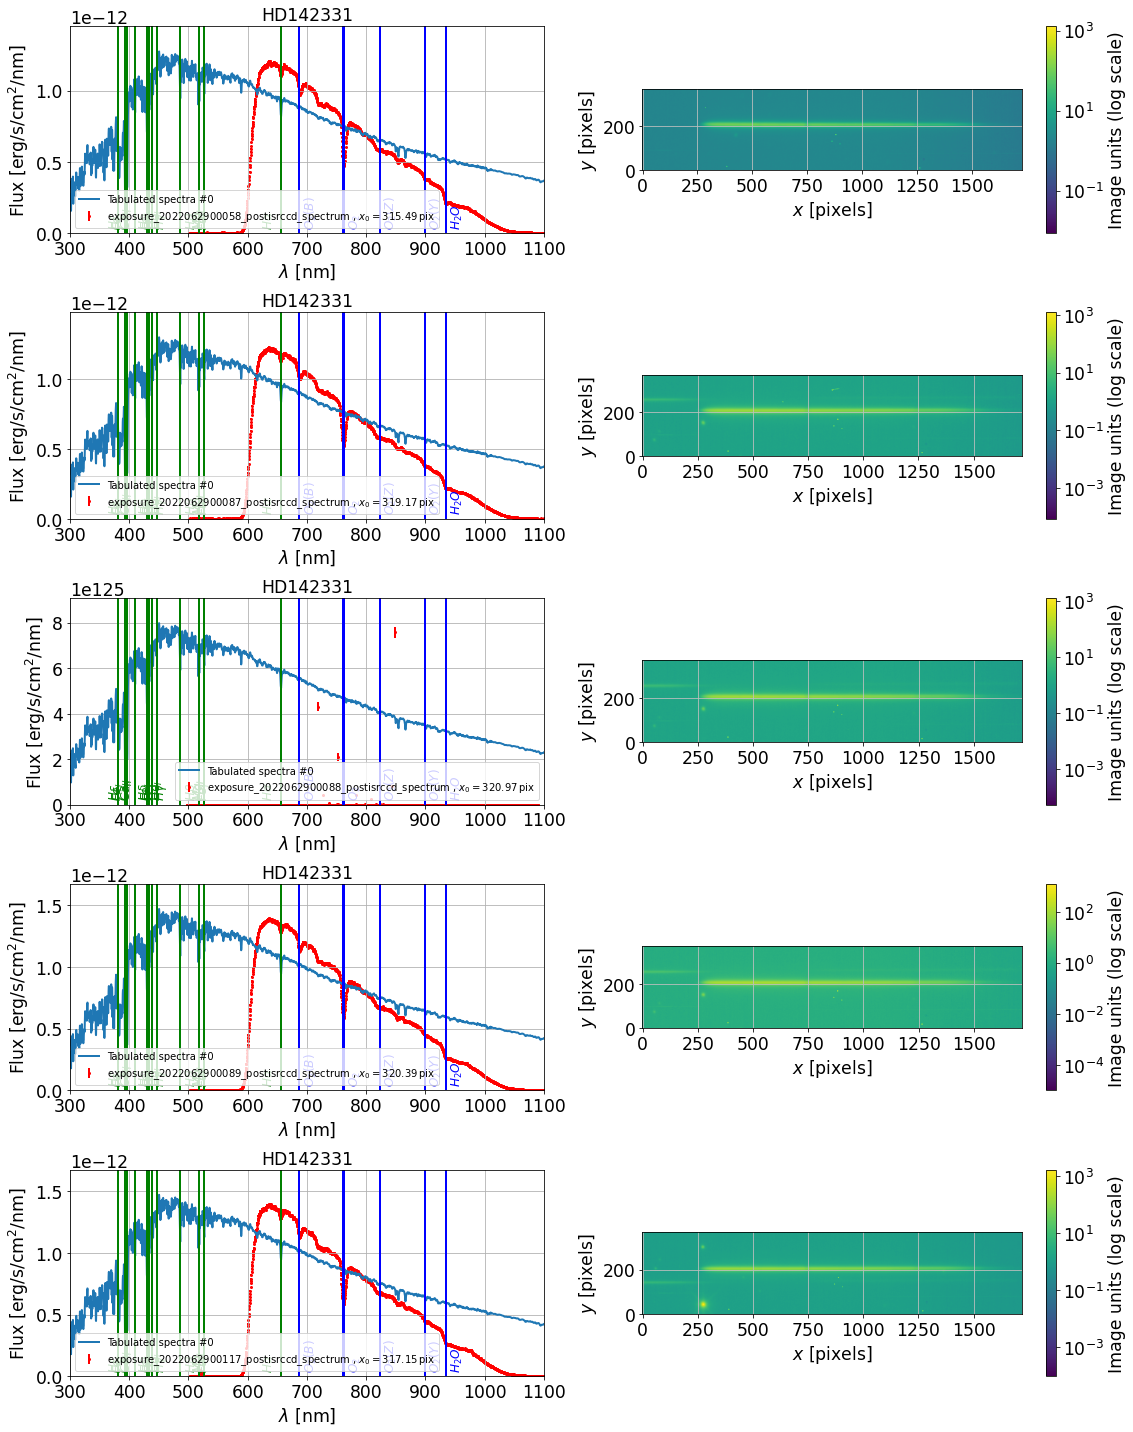

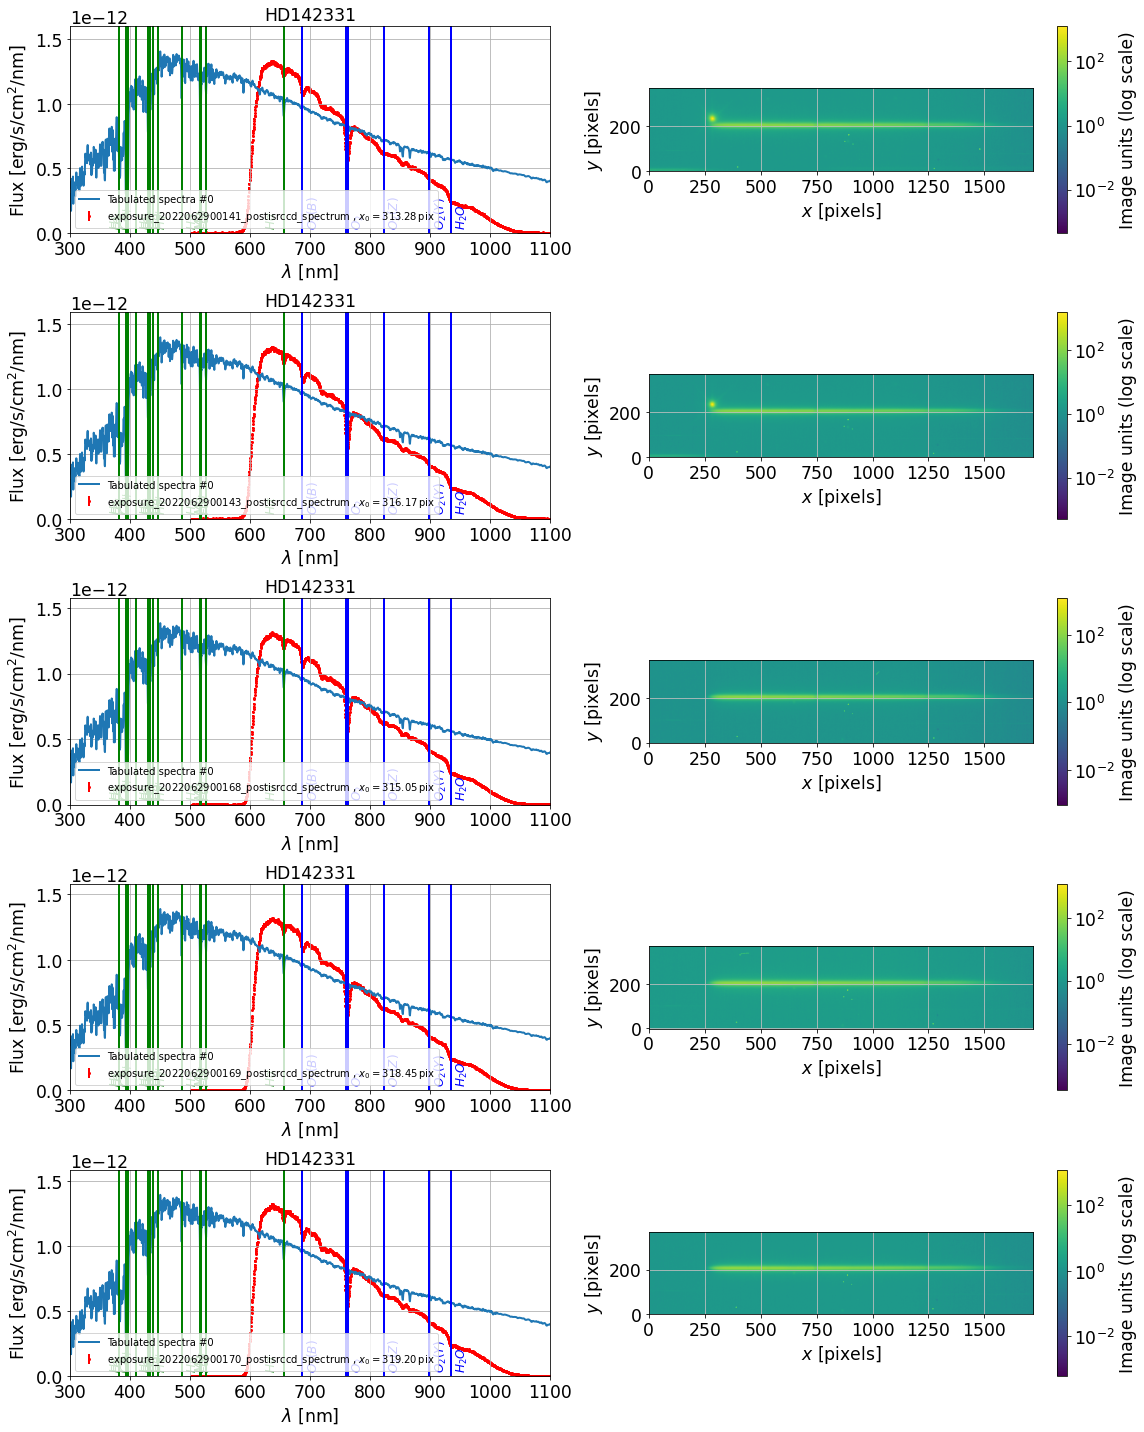

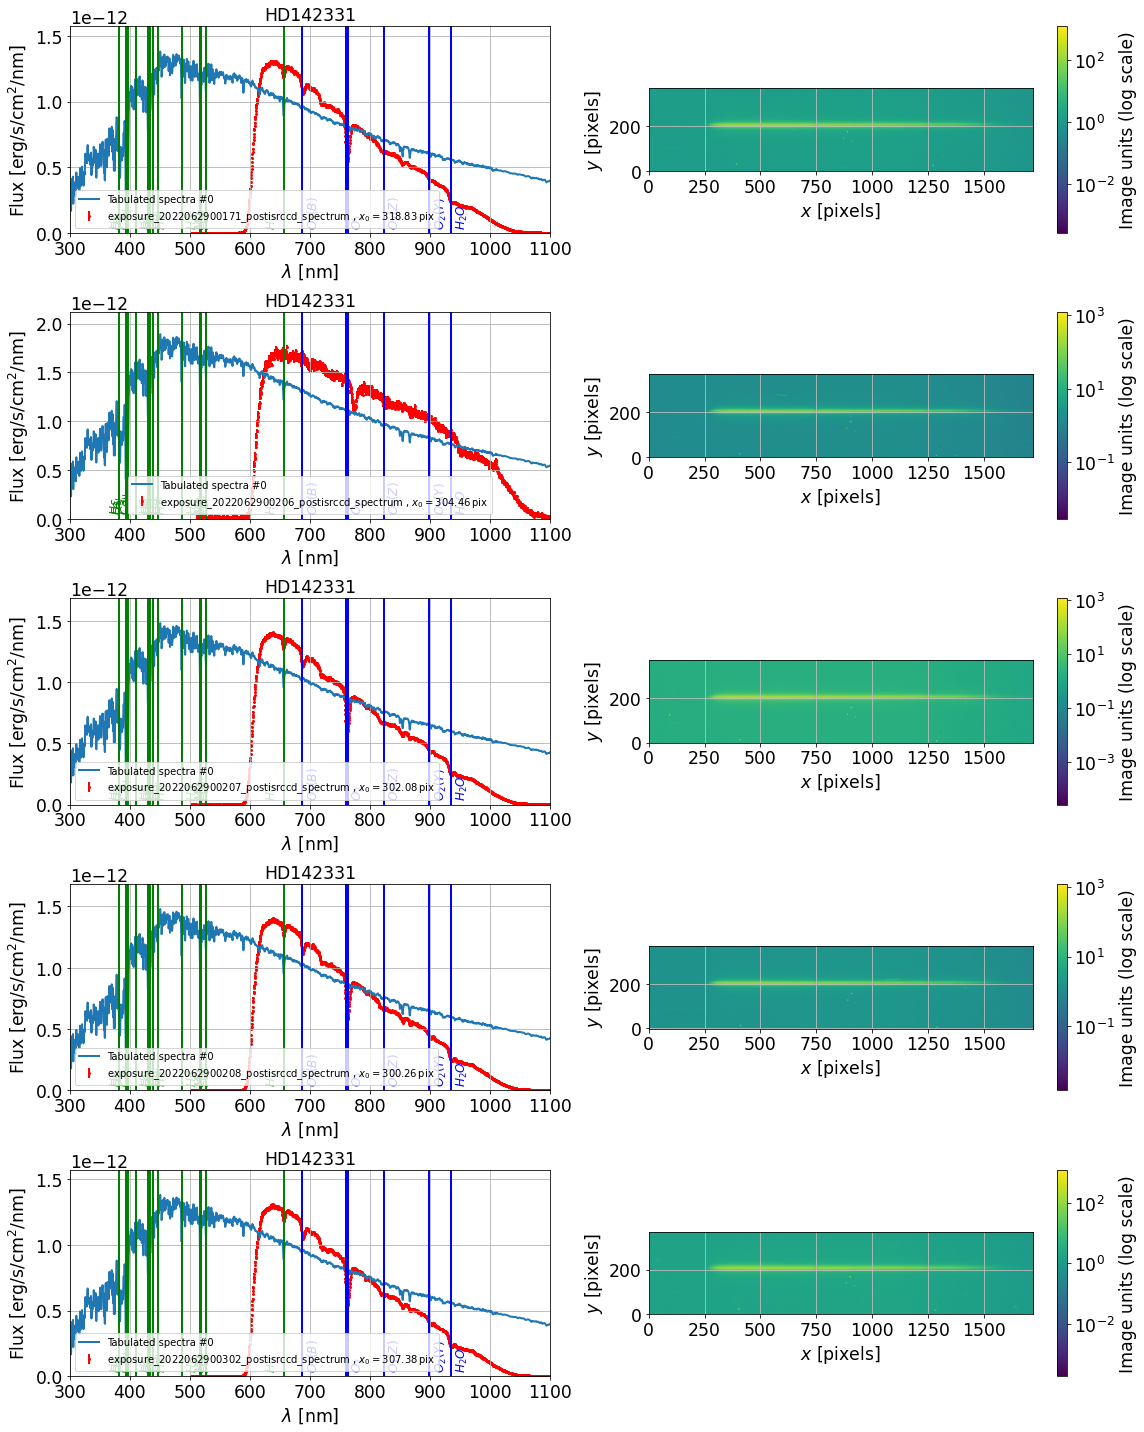

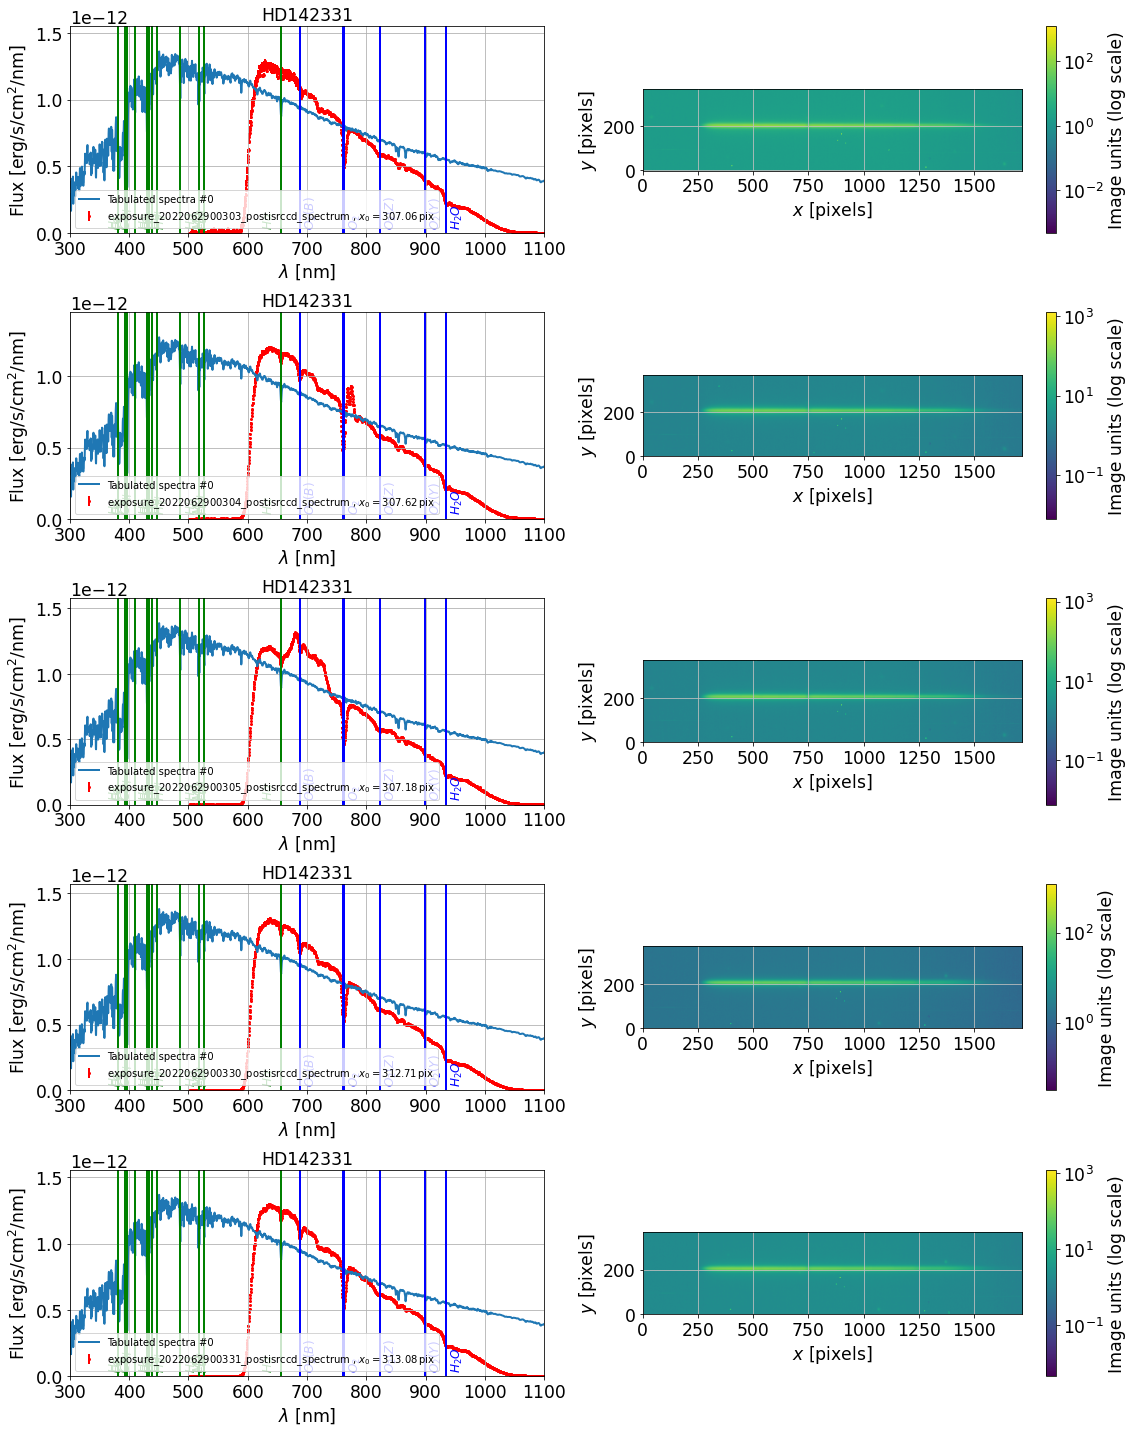

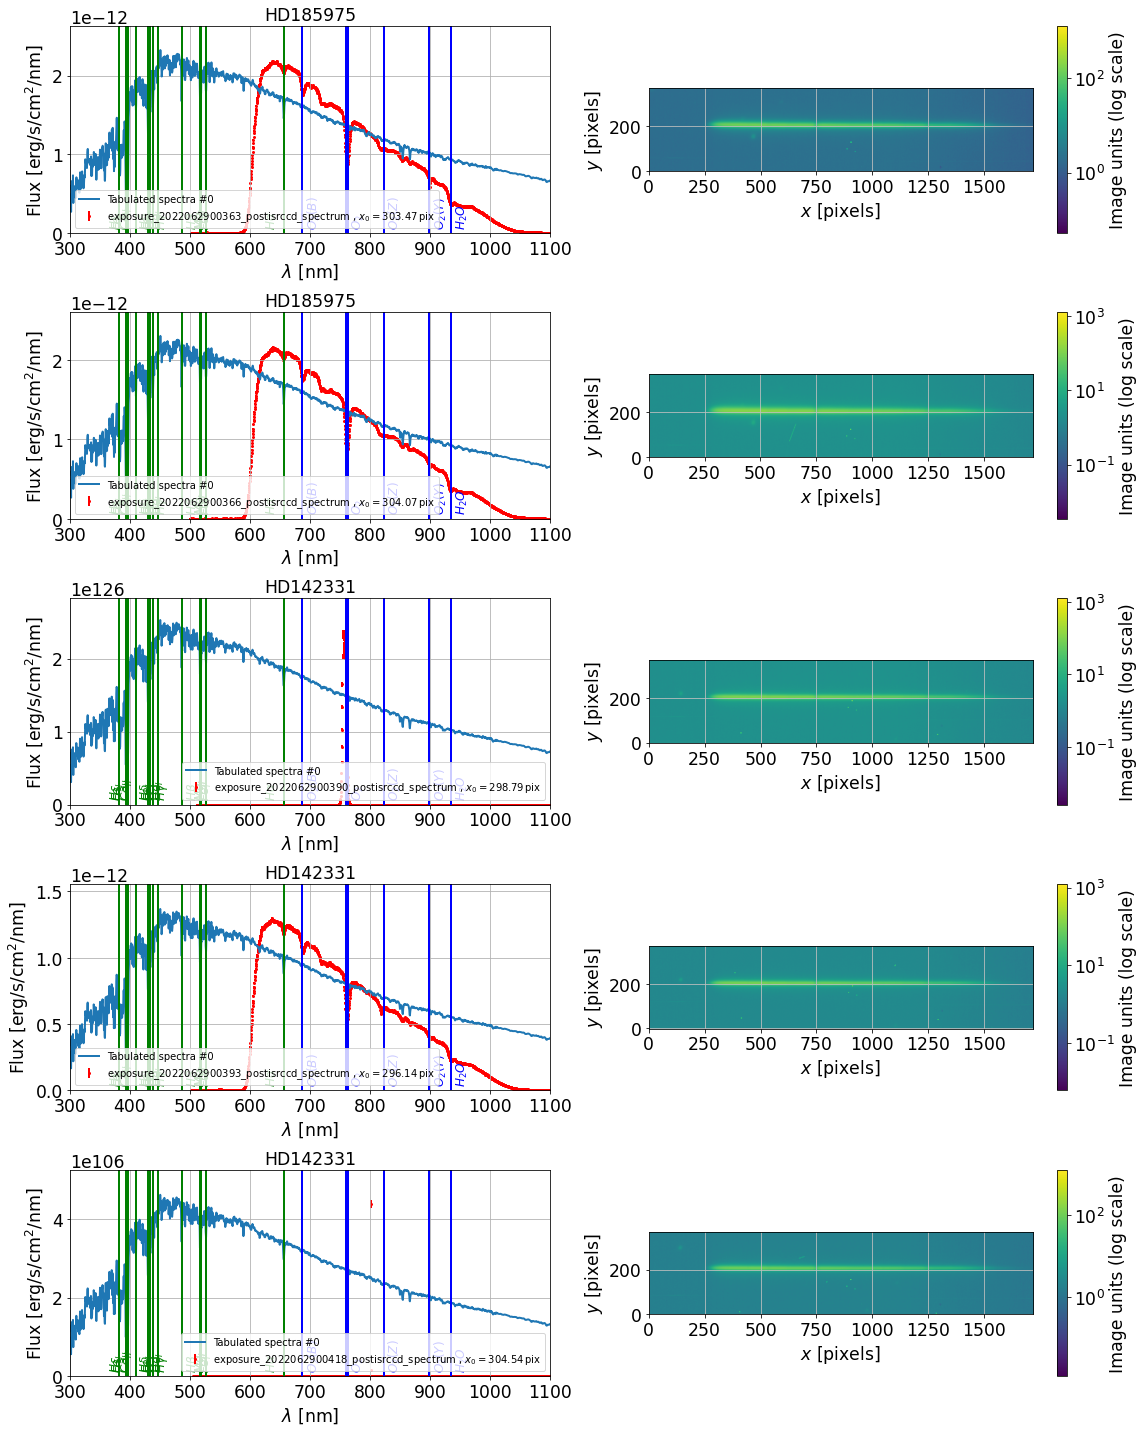

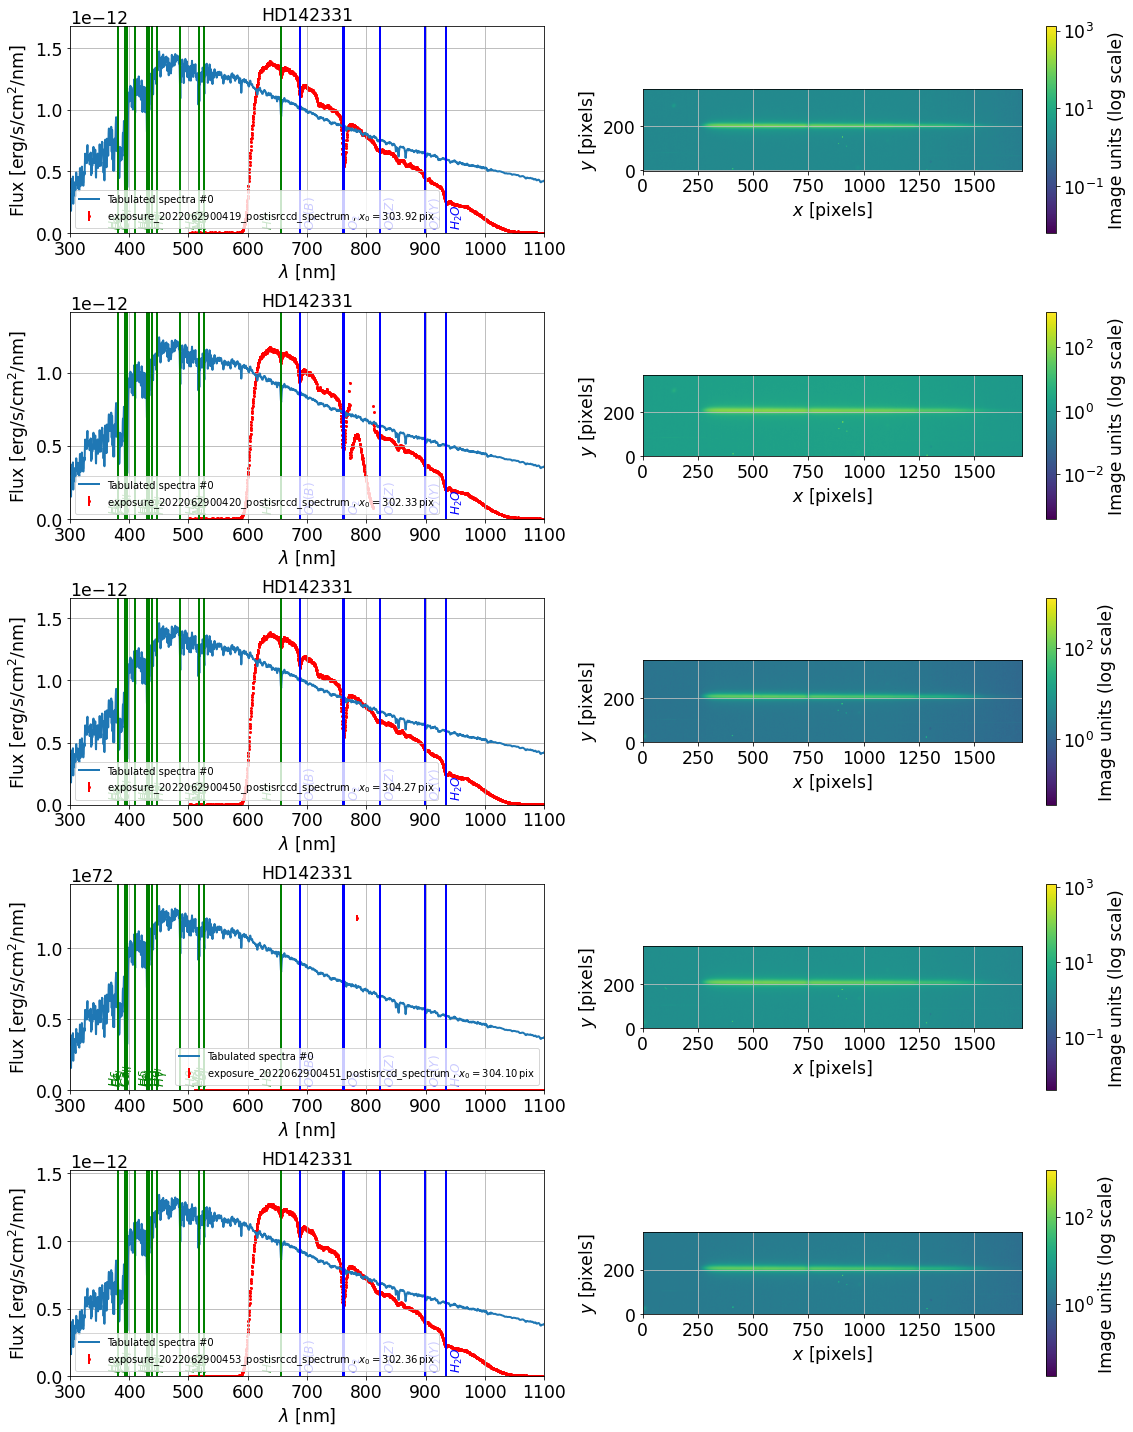

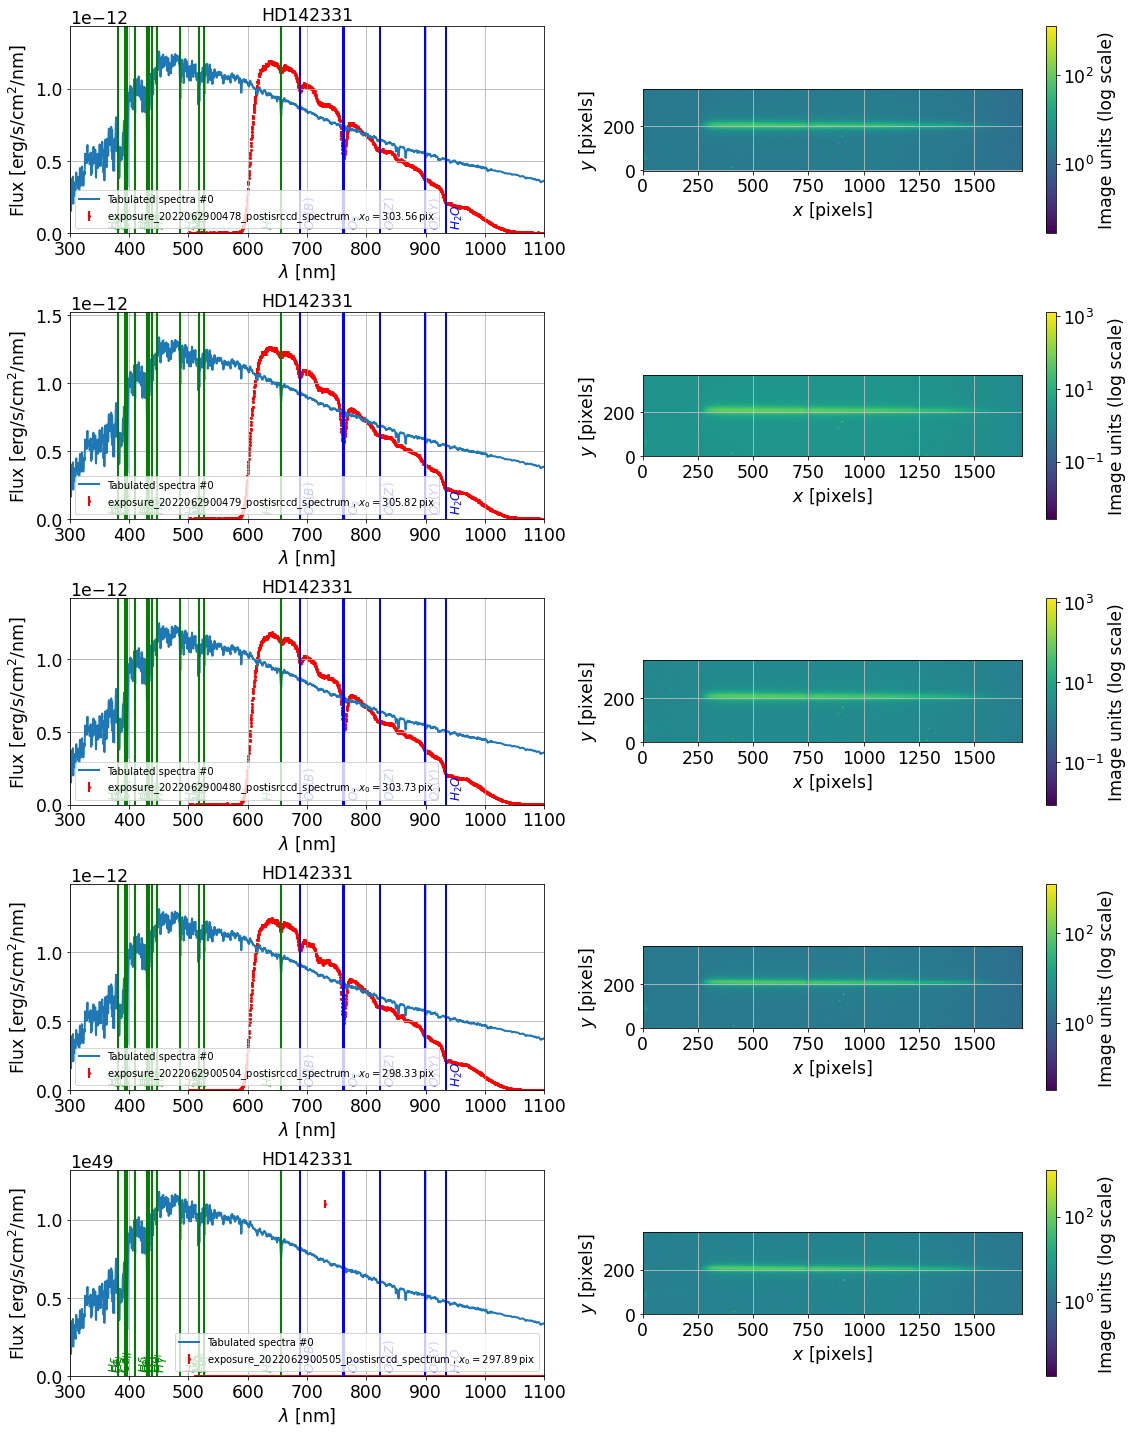

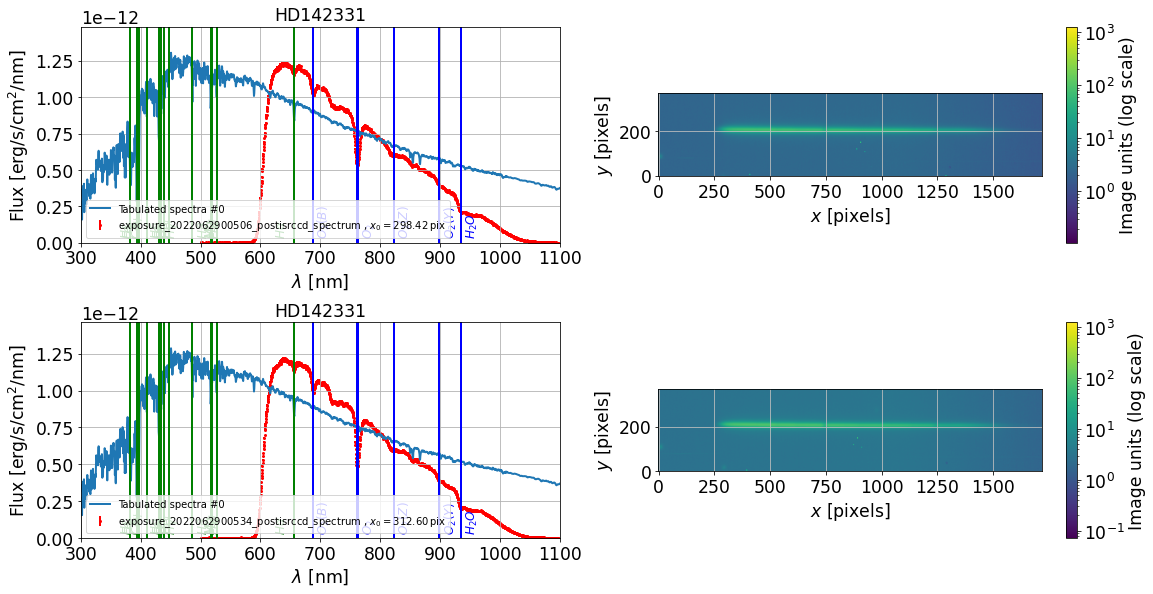

In [62]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

### Summary spectra

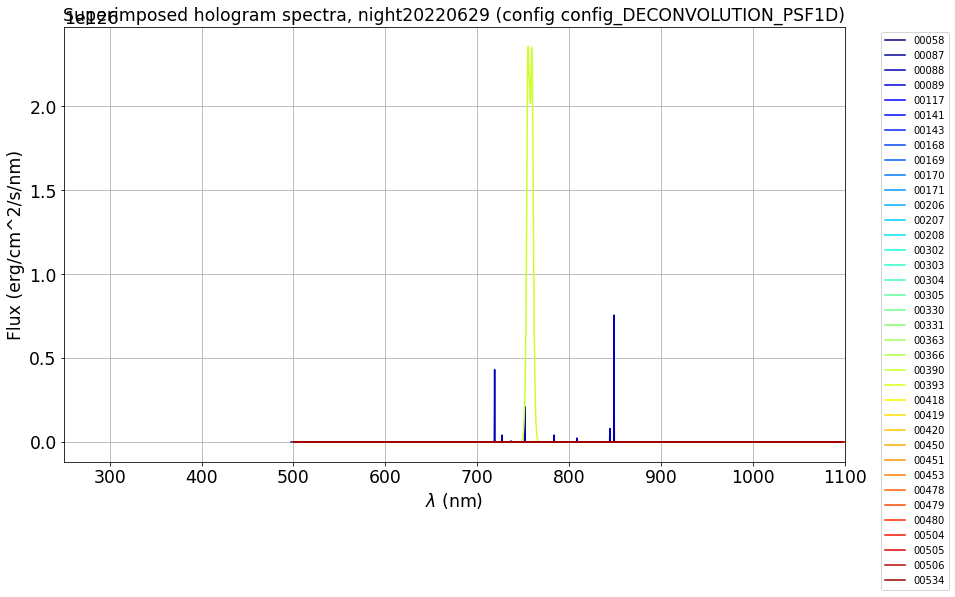

In [63]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [64]:
all_figs.append(sumfig)

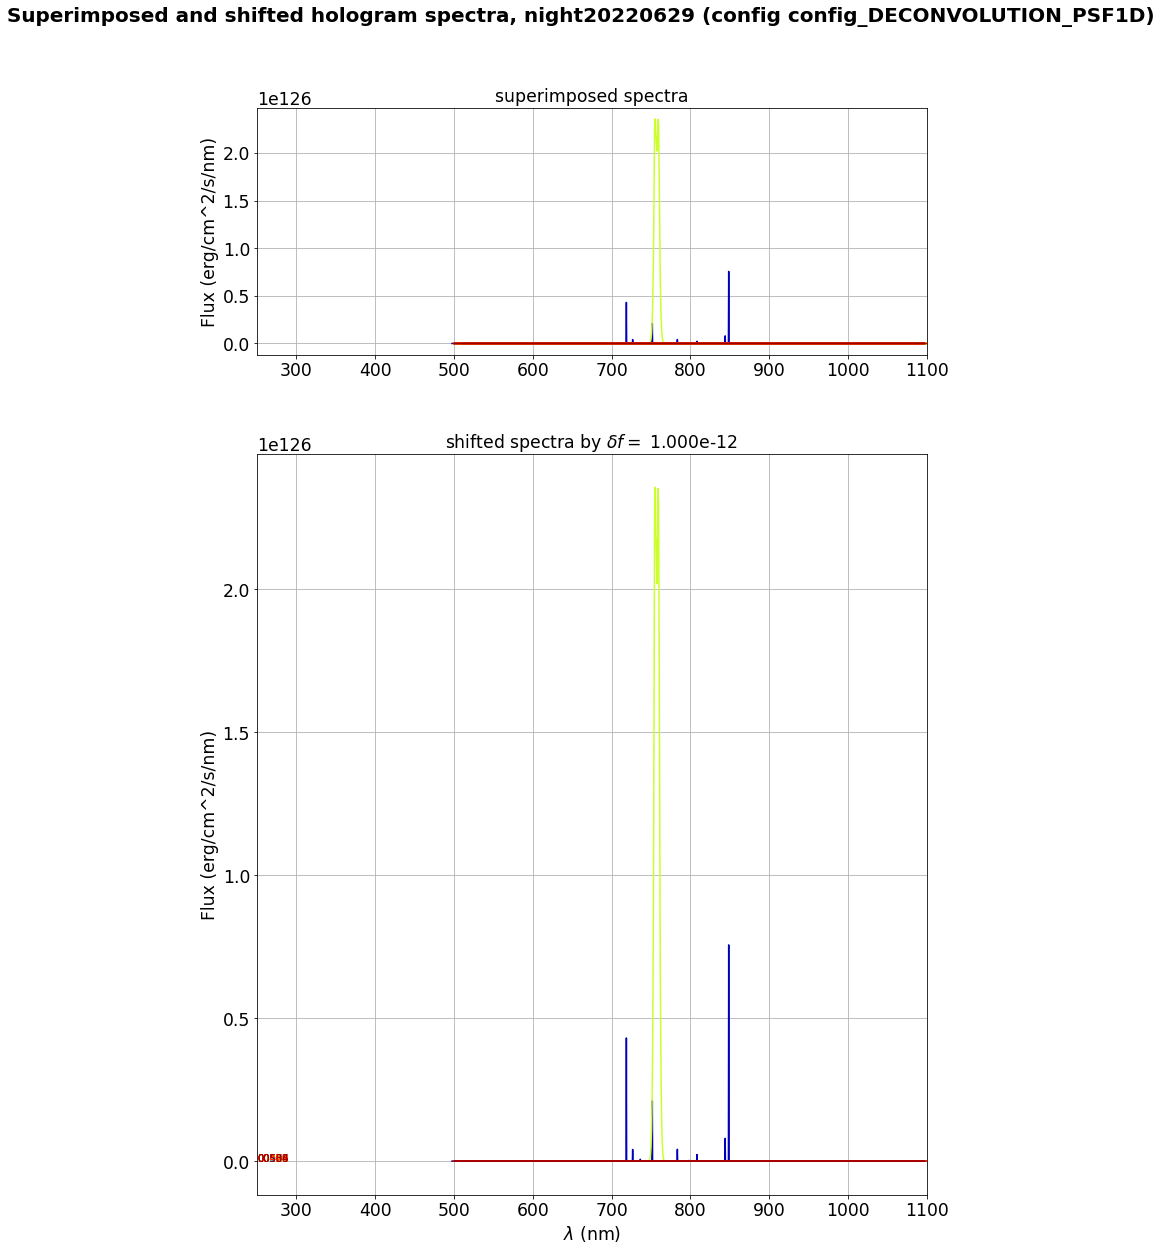

In [65]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [66]:
all_figs.append(sumfig2)

### Save in pdf file

In [67]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

3 ) exposure_2022062900089_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_PSF1D/20220629/2022062900089/basespec/exposure_2022062900089_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-06-30T00:33:38.095
set expo to 30.0
set airmass to 1.16193748088144
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -8.580388888888889
set hour_angle to -23.46619711892746
set temperature to 9.5
set pressure to 744.35
set humidity to 14.0
set lambda_ref to 758.5700181405618
set parallactic_angle to -137.8332006346826
target_name = HD142331, Selected object name for Simbad : HD142331


2022-09-22 15:52:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_76 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 142331 15 54 19.7884 -08 34 49.370 ... -0.0002360                1


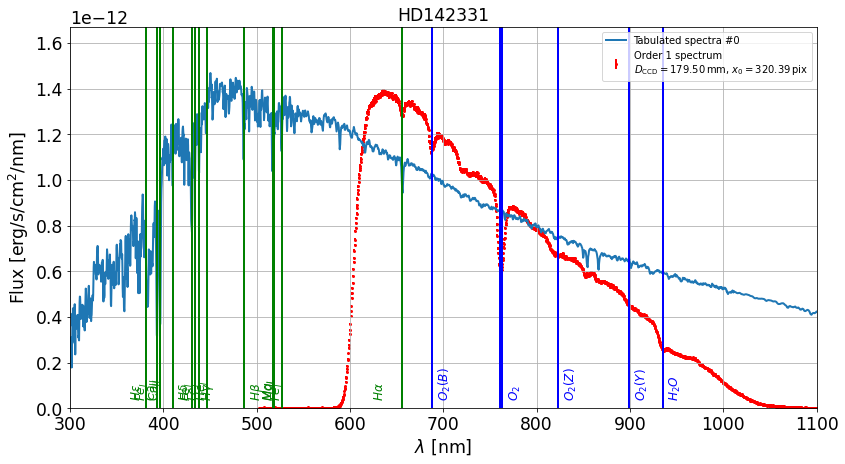

In [68]:
idx=3

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)

#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

In [69]:
all_figs.append(fig)

## Info

In [70]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [71]:
df_infos.set_index('idx',inplace=True)

In [72]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [73]:
all_reftime=np.array(all_reftime)

In [74]:
df_infos["reftime"]=all_reftime

In [75]:
NN = len(df_infos)

In [76]:
df_infos

object                 date_obs   airmass  temperature  pressure  \
idx                                                                       
0    HD142331  2022-06-29T23:22:37.887  1.388780          9.5    743.85   
1    HD142331  2022-06-30T00:32:12.198  1.164825          9.6    744.35   
2    HD142331  2022-06-30T00:32:55.197  1.163372          9.6    744.35   
3    HD142331  2022-06-30T00:33:38.095  1.161937          9.5    744.35   
4    HD142331  2022-06-30T00:52:53.929  1.128311          9.9    744.35   
5    HD142331  2022-06-30T01:09:20.071  1.106639          9.6    744.20   
6    HD142331  2022-06-30T01:10:45.940  1.105030          9.7    744.30   
7    HD142331  2022-06-30T01:27:54.494  1.089167          9.9    744.25   
8    HD142331  2022-06-30T01:28:37.468  1.088634          9.9    744.25   
9    HD142331  2022-06-30T01:29:20.379  1.088111          9.9    744.25   
10   HD142331  2022-06-30T01:30:03.413  1.087597          9.9    744.25   
11   HD142331  2022-06-30T01:57:50.734  1.075492          9.9    744.40   
12   HD142331  2022-06-30T01:58:33.862  1.075372          9.9    744.40   
13   HD142331  2022-06-30T01:59:16.887  1.075261          9.9    744.40   
14   HD142331  2022-06-30T03:22:40.072  1.130894         10.0    744.30   
15   HD142331  2022-06-30T03:23:22.975  1.132005         10.0    744.30   
16   HD142331  2022-06-30T03:24:06.121  1.133133         10.1    744.30   
17   HD142331  2022-06-30T03:24:49.118  1.134272         10.0    744.30   
18   HD142331  2022-06-30T03:43:32.887  1.168659         10.1    744.10   
19   HD142331  2022-06-30T03:44:16.022  1.170164         10.1    744.05   
20   HD185975  2022-06-30T04:09:12.518  1.867517         10.2    743.85   
21   HD185975  2022-06-30T04:11:21.596  1.866717         10.1    743.80   
22   HD142331  2022-06-30T04:28:53.760  1.295798         10.2    743.70   
23   HD142331  2022-06-30T04:31:02.609  1.303697         10.2    743.75   
24   HD142331  2022-06-30T04:48:03.322  1.373892         10.1    743.65   
25   HD142331  2022-06-30T04:48:46.341  1.377158         10.1    743.65   
26   HD142331  2022-06-30T04:49:29.273  1.380459         10.1    743.65   
27   HD142331  2022-06-30T05:14:34.027  1.515610         10.3    743.70   
28   HD142331  2022-06-30T05:15:16.921  1.520101         10.2    743.70   
29   HD142331  2022-06-30T05:16:42.937  1.529220         10.3    743.70   
30   HD142331  2022-06-30T05:33:46.746  1.651453         10.2    743.70   
31   HD142331  2022-06-30T05:34:29.749  1.657194         10.2    743.70   
32   HD142331  2022-06-30T05:35:12.762  1.662979         10.2    743.75   
33   HD142331  2022-06-30T05:51:28.246  1.810607         10.3    743.70   
34   HD142331  2022-06-30T05:52:11.149  1.817910         10.3    743.70   
35   HD142331  2022-06-30T05:52:54.221  1.825284         10.4    743.75   
36   HD142331  2022-06-30T06:12:07.585  2.054928         10.3    743.45   

     humidity   reftime  
idx                      
0        12.0  0.000000  
1        13.0  1.159531  
2        13.0  1.171475  
3        14.0  1.183391  
4        17.0  1.504456  
5        15.0  1.778384  
6        16.0  1.802237  
7        16.0  2.087946  
8        16.0  2.099884  
9        16.0  2.111803  
10       16.0  2.123757  
11       15.0  2.586902  
12       15.0  2.598882  
13       15.0  2.610833  
14        9.0  4.000607  
15        9.0  4.012524  
16        9.0  4.024509  
17        9.0  4.036453  
18       10.0  4.348611  
19        9.0  4.360593  
20       10.0  4.776286  
21       10.0  4.812141  
22       11.0  5.104409  
23       10.0  5.140201  
24       11.0  5.423732  
25       11.0  5.435682  
26       11.0  5.447607  
27       12.0  5.865594  
28       12.0  5.877509  
29       12.0  5.901403  
30       12.0  6.185794  
31       12.0  6.197739  
32       12.0  6.209687  
33       12.0  6.480655  
34       12.0  6.492573  
35       12.0  6.504537  
36       12.0  6.824916

In [77]:
summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
df_infos.to_csv(summary_file)

Text(0.5, 1.0, 'airmassvs vs date')

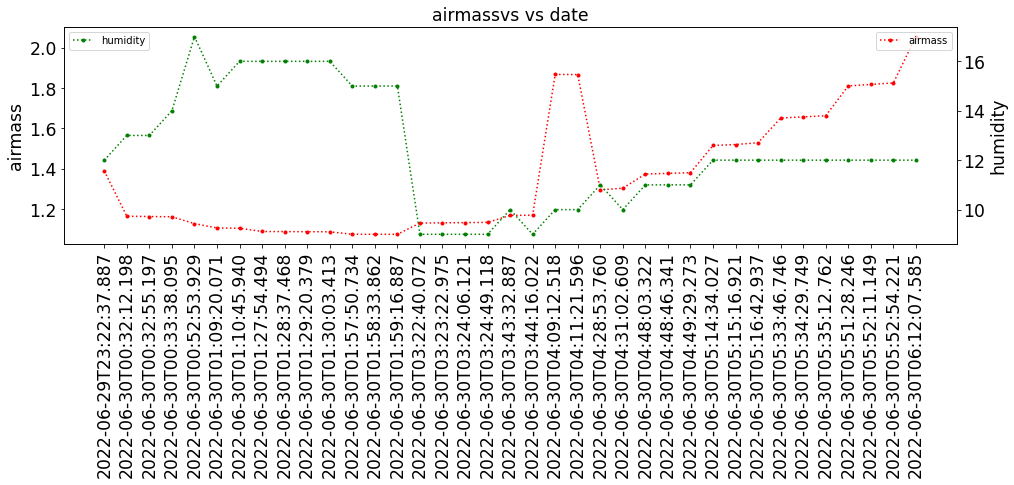

In [78]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

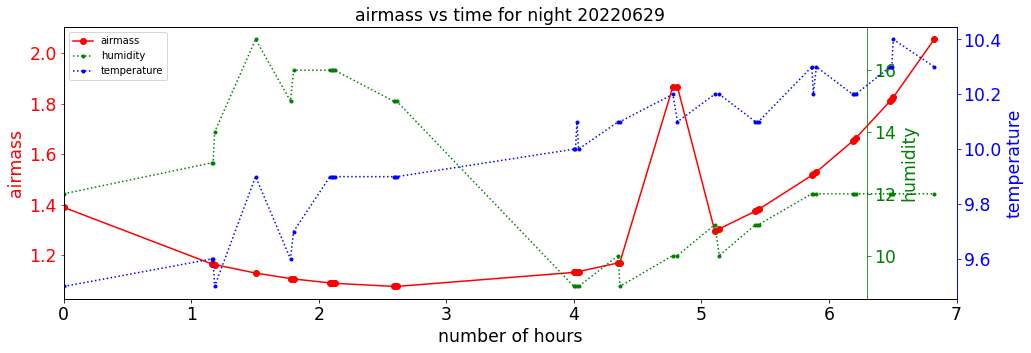

In [79]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [80]:
all_figs.append(fig)

# Header info

In [81]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [82]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1718                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
DATE    = '2022-06-30T06:12:07.585'                                             
MJD     =    59760.25842112256                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
TESTTYPE= 'OBJECT  '                                                            
IMGTYPE = 'OBJECT  '                                                            
TEMP_SET=   -94.150000000000

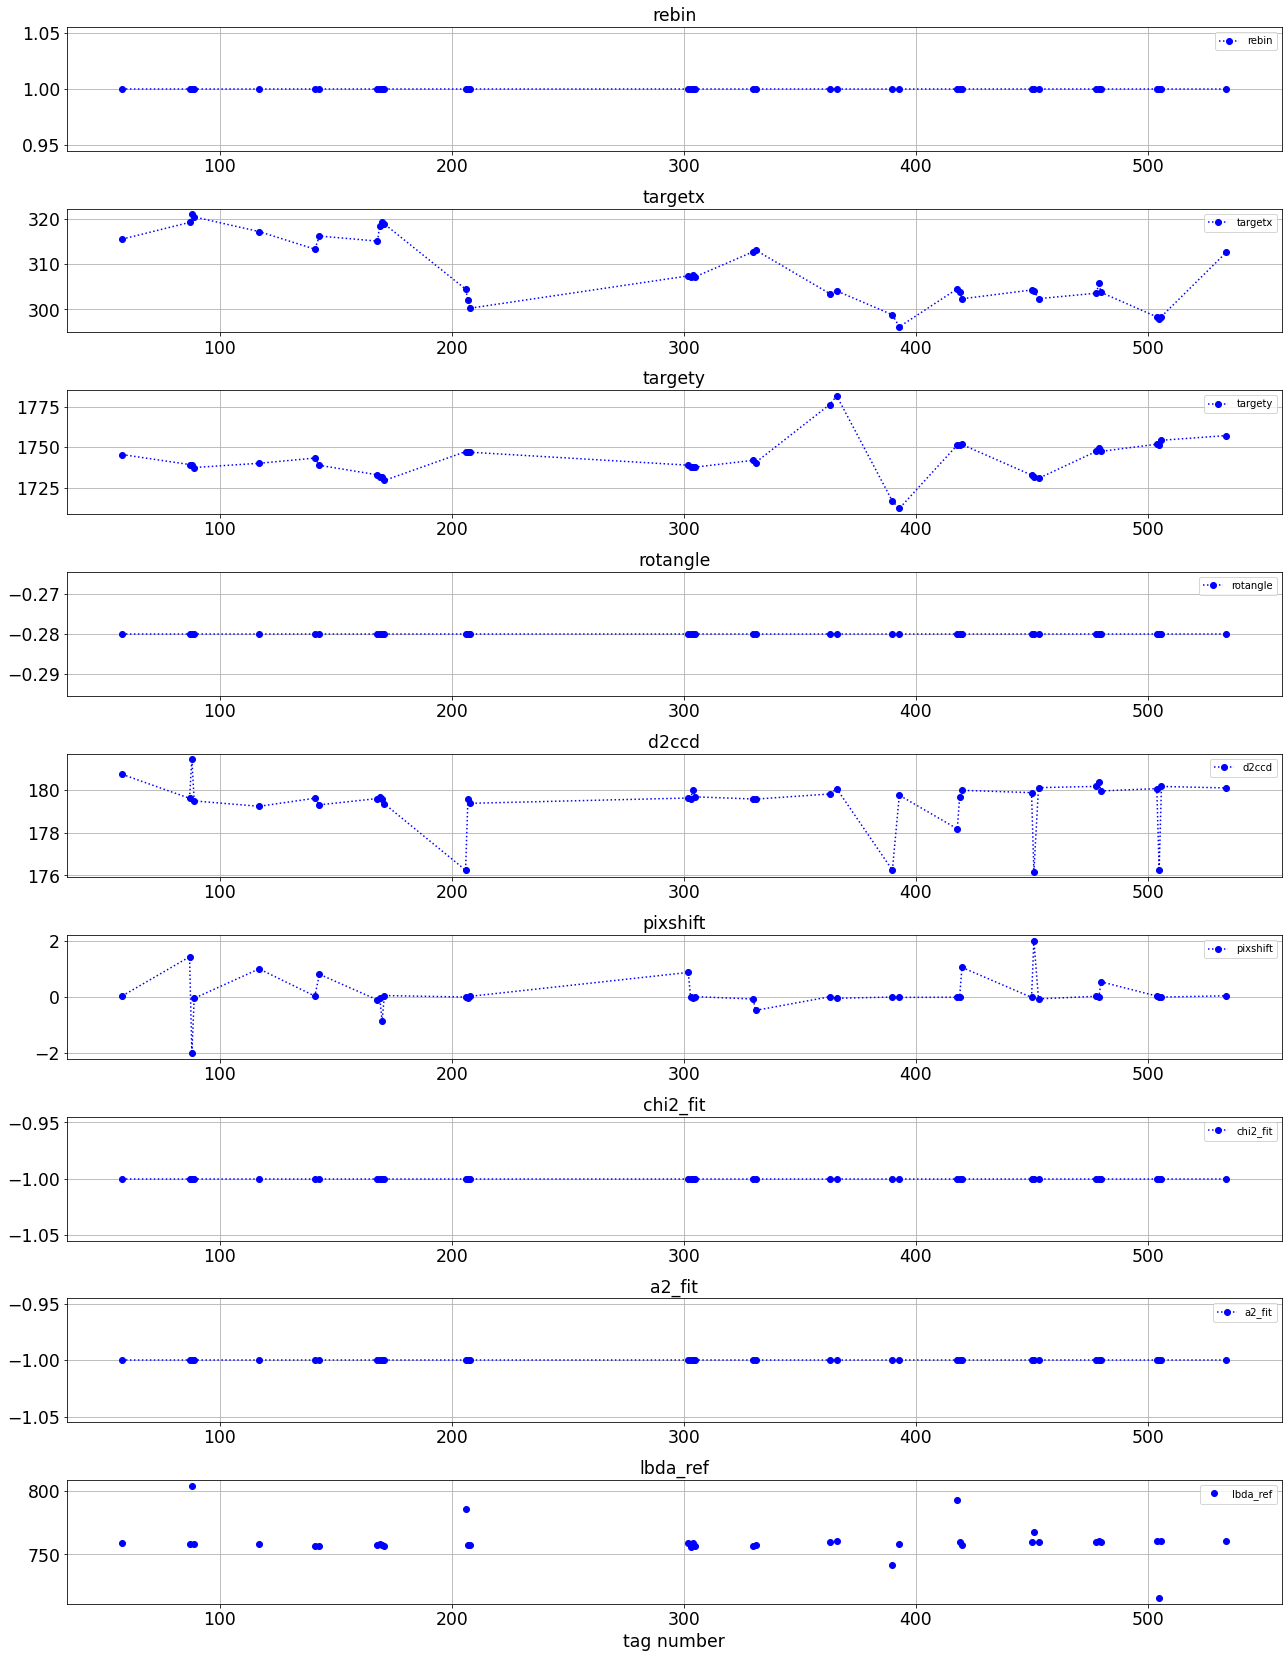

In [83]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [84]:
all_figs.append(fig)

# Write in pdf file

In [85]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configmode}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configmode}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

# write in pickles files

In [86]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [87]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{configdir}.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{configdir}_recalib.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [88]:
pkl_infilename=pkl_outfilename

In [89]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [90]:
#content

In [91]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2022062900058_postisrccd_spectrum.fits',
 {'number': 58.0,
  'object': 'HD142331',
  'dateobs': '2022-06-29T23:22:37.887',
  'refhour': 0.0,
  'airmass': 1.388780155371592,
  'pressure': 743.85,
  'temperature': 9.5,
  'humidity': 12.0,
  'targetx_pix': 315.4923573241055,
  'targety_pix': 1745.462043227314,
  'rotangle': -0.28,
  'd2ccd': 180.7472376256118,
  'all_lambdas': array([ 501.46676923,  501.81832237,  502.1698708 , ..., 1098.52059079,
         1098.85987832, 1099.19915636]),
  'all_fluxes': array([-3.74812844e-15, -1.85498104e-15, -3.94223062e-15, ...,
         -4.61836430e-16, -1.21808481e-15, -8.58320584e-16]),
  'all_fluxes_err': array([2.37184783e-15, 2.39154908e-15, 2.37066125e-15, ...,
         1.03075559e-15, 1.02272294e-15, 1.02863574e-15]),
  'all_lambdas_order2': array([250.73338461, 250.90916118, 251.0849354 , ..., 549.2602954 ,
         549.42993916, 549.59957818]),
  'all_fluxes_order2': array([0., 0., 0., ..., 0., 0., 0.]),
  'all_fluxes_err_order2': 